# <center>makeManuscript1Figures JN</center>
This jupyter-notebook is used to make a set of manuscript figures

<center>Figure 1: ....</center>
<br>
<br>





# Figure 1: Reconstructed bathymetry (PD, 60 Ma) with LOSCAR box model.

In [ ]:
#################################################
#################### Imports ####################
#################################################

# For reading matlab files that store plate boundaries.
import scipy.io
import os

# For plotting
from netCDF4 import Dataset
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

###################################
## Define Functions for Figure 1 ##
###################################
def load_netcdf_data(age):
    # Read bathymetry file.
    ds = Dataset(os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age))

    # Assign data to variables
    lon, lat = np.meshgrid(ds['lon'][:], ds['lat'][:]);
    z = ds['z'][:].data;
    continents = ds['z'][:].mask;
    continentsnew = cp.deepcopy(continents).astype(float)
    continentsnew[continentsnew==0] = np.nan

    
    # Close dataset
    ds.close();
    
    # Return variables
    return lon, lat, z, continentsnew

def remove_non_unique_rows(arr):
    # Count occurrences of each row
    unique_rows, counts = np.unique(arr, axis=0, return_counts=True)
    # Only keep rows that appear once
    unique_only = unique_rows[counts == 1]
    return unique_only

def readBoundaries(age, pacificValues=[1,0]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.getcwd()+'/PNAS_Bogumil_Results/basinPolygons/Earth{}Ma_basin_poly.mat'.format(age))

    # Print variable names in the file (ignoring MATLAB metadata entries)
    variable_names = [key for key in mat_data.keys() if not key.startswith('__')]
    #print("Variables in .mat file:", variable_names);

    # Access a specific variable (replace 'your_variable_name' as needed)
    boundaries = mat_data['Earth{}Ma'.format(age)][0][0];
    
    # Merge two Pacific boundaries
    if pacificValues is not None:
        x = np.vstack( (boundaries[pacificValues[0]], boundaries[pacificValues[1]]) )
        x = remove_non_unique_rows(x)
        boundariesOut = np.array(np.arange(len(boundaries)-1), dtype=object)
        boundariesOut[0] = x

        cnt = 0;
        for i in range(len(boundaries)):
            #print(i, (pacificValues[0]==i), (pacificValues[1]==i), ((pacificValues[0]==i) | (pacificValues[1]==i)))
            if not ((pacificValues[0]==i) | (pacificValues[1]==i)):
                #print(i)
                boundariesOut[cnt+1] = boundaries[i]
                boundariesOut[cnt+1] = boundaries[i]
                cnt+=1;
    else:
        boundariesOut = np.array(np.arange(len(boundaries)), dtype=object)
        for i in range(len(boundaries)):
            boundariesOut[i] = boundaries[i]
        

    return boundariesOut



############################################################################
# Read and plot bathymetry and basin boundaries from Bogumil et al. (2024) #
############################################################################

# Load NetCDF file
age1 = 0; age2 = 60;
lon, lat, z1, continents1 = load_netcdf_data(age1)
lon, lat, z2, continents2 = load_netcdf_data(age2)

# Load basin boundaries
boundaries1 = readBoundaries(age1, None)
boundaries2 = readBoundaries(age2, None)

# Reduce resolution
factor = 1
lon = lon[::factor].T[::factor].T
lat = lat[::factor].T[::factor].T
z1  = z1[::factor].T[::factor].T
z2  = z2[::factor].T[::factor].T
continents1 = continents1[::factor].T[::factor].T
continents2 = continents2[::factor].T[::factor].T


# Create the figure
## Set up projection and figure
proj = ccrs.Robinson()
fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 10),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

# Define common color scale
vmin = np.nanmin([np.nanmin(z1), np.nanmin(z2)])
vmax = np.nanmax([np.nanmax(z1), np.nanmax(z2)])
vmin = 0
vmax = 7000


# Example polygon (replace with your actual lat/lon)
poly_lats = [-10, -10, 0, 0, -10]
poly_lons = [100, 110, 110, 100, 100]
polygon = Polygon(zip(poly_lons, poly_lats))

# Sample reversed blue cmap for bathymetry
N = 35
blues_cm = mpl.colormaps['Blues'].resampled(N)

# Plot first dataset
## Plot bathymetry
mesh11 = axs[0].pcolormesh(lon, lat, z1, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh12 = axs[0].pcolormesh(lon, lat, continents1, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
colors = ['black', 'black', 'black', 'black', 'black']

#colors = ['black', 'black', 'red', 'green']
cnt=0
for boundary in boundaries1:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[0].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[0].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Plot second dataset
## Plot bathymetry
mesh21 = axs[1].pcolormesh(lon, lat, z2, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh22 = axs[1].pcolormesh(lon, lat, continents2, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
#colors = ['black', 'black', 'blue', 'red', 'white']
cnt=0
for boundary in boundaries2:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[1].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[1].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh21, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Bathymetry")

# Save figure
plt.savefig("F1_PNAS_Bogumil_Results/ExoCycle_ModelPaper_Figure1.png", dpi=600, transparent=True)
#plt.savefig("F1_PNAS_Bogumil_Results/ExoCycle_ModelPaper_Figure1.svg", transparent=True)



# Figure 2: 
Plots diagrams of community detection algorithms (Louvain and Girvan-Newman) for figure 2 of manuscript.

Note that coloring of nodes was done in a figure diagram editor (inkscape).

Removing edge from node pair 5-6
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 0-3
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 0-3
Removing edge from node pair 4-7


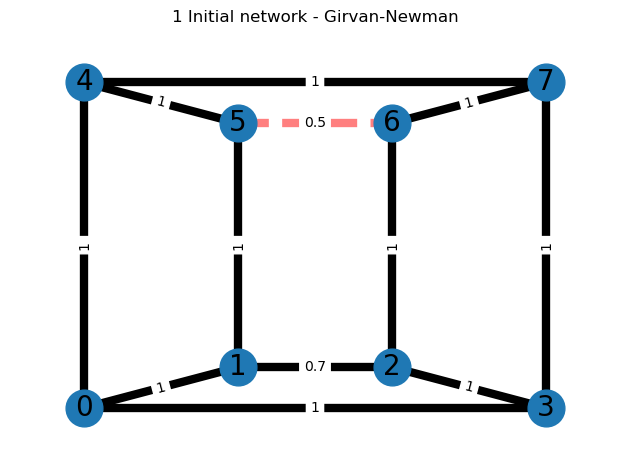

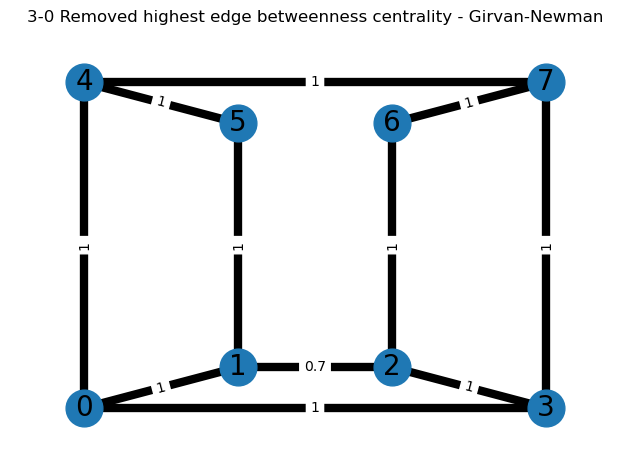

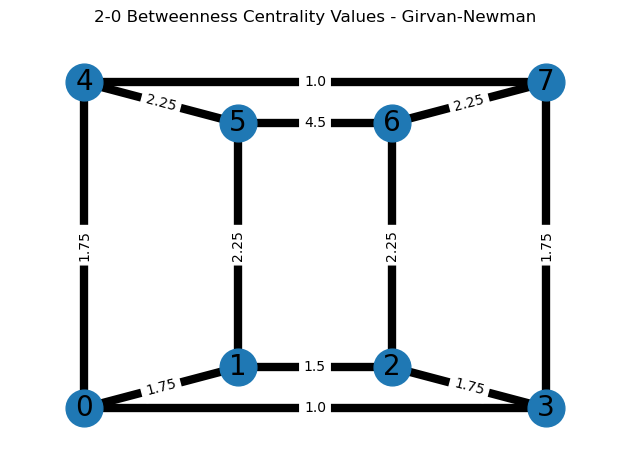

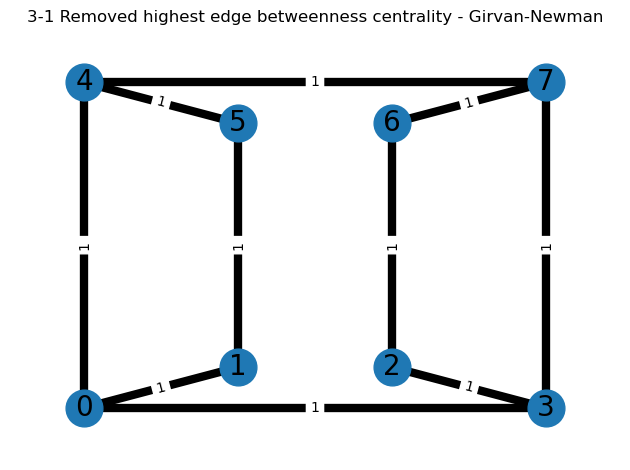

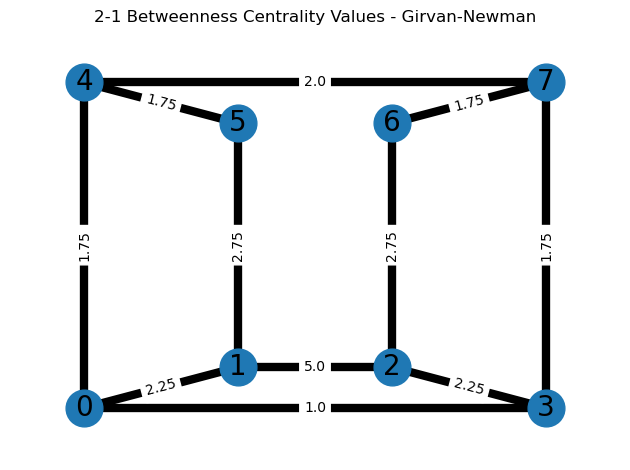

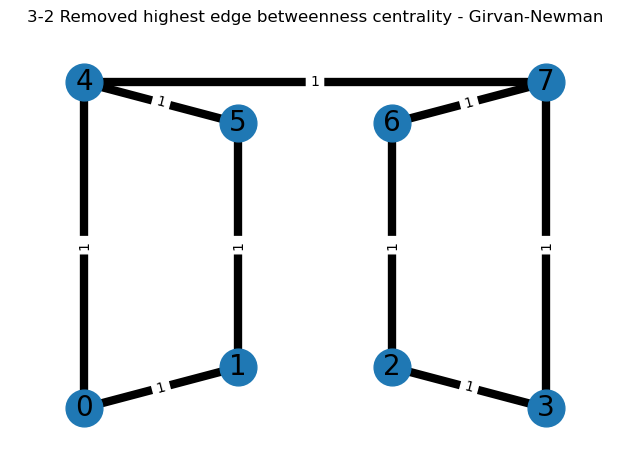

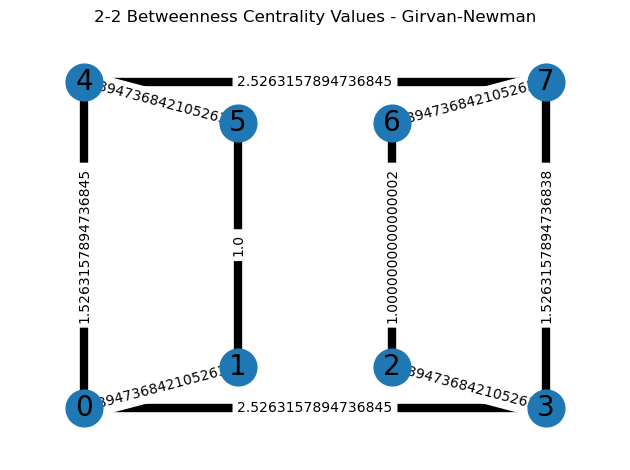

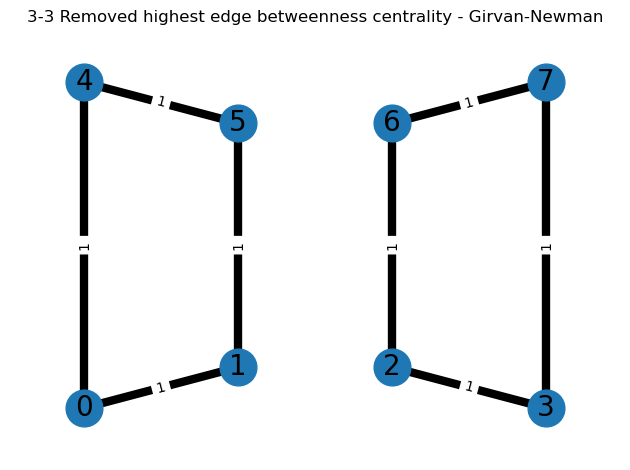

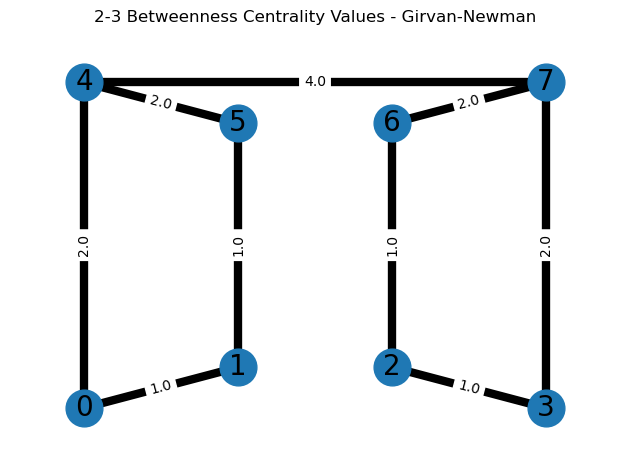

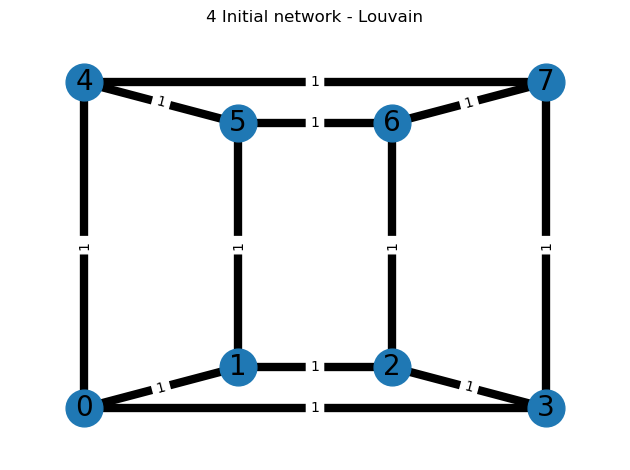

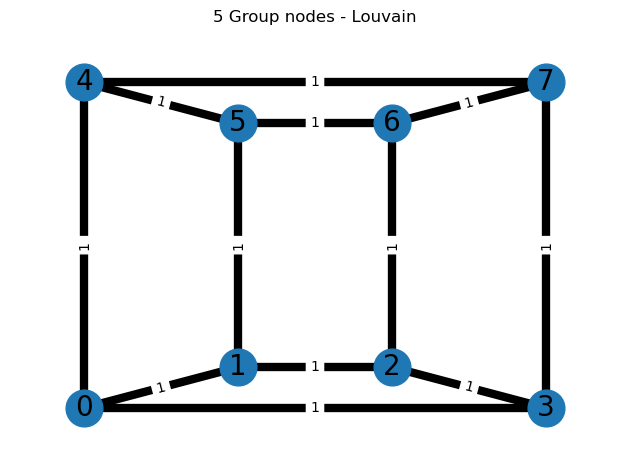

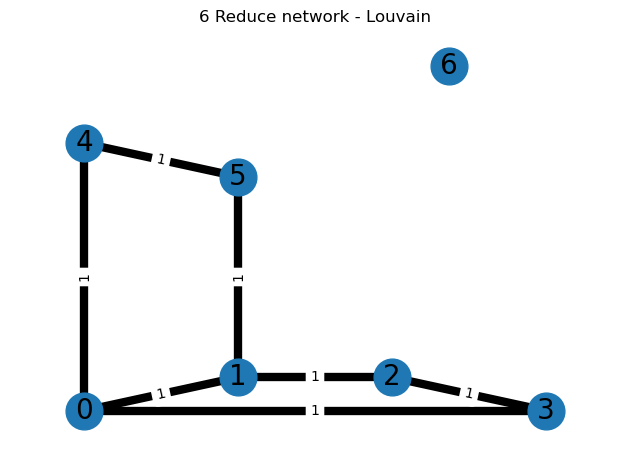

In [11]:
#################################################
#################### Imports ####################
#################################################
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Create the directory if it doesn't exist
directory_name = os.getcwd()+"/figures/CommunityDetectionMethodsPaper/diagrams2"
os.makedirs(directory_name, exist_ok=True)


###################################
## Define Functions for Figure 2 ##
###################################
class NeighborNetwork():
    """
    createNeighborNetwork is a function designed
    to create an networkx spatial graph with neighbor
    node edges. Node edges are given a value of 1,
    but can be modified using a method.
    
    """
    
    def __init__(self, size=(2,8)):
        """
        Initializes NeighborNetwork.
        
        Parameters
        -----------
        size : TUPLE
            A tuple describing the size of the output
            graph. The graph will have size[0]*size[1]
            nodes.
        """
        # Construct new graph
        self.G = nx.Graph()
        
        # Add nodes
        ## Create numpy array of input size
        rows = size[0]
        cols = size[1]
        self.XX, self.YY = np.meshgrid(np.arange(cols), np.arange(rows))
        
        # Create nodes
        self.pos = [];
        for x, y in zip(self.XX.flatten(), self.YY.flatten()):
            currentNodeid = x + y*cols;
            self.G.add_node(currentNodeid, pos=(x-(cols-1)/2,
                                                (y-(rows-1)/2)*np.abs(0.4*(x-(cols-1)/2))+(y-(rows-1)/2))
                           )
            self.pos.append(currentNodeid)
        self.pos=np.array(self.pos);
        
        # Iterate over each nodes' xy position adding edges
        # adding each edge.
        for x, y in zip(self.XX.flatten(), self.YY.flatten()):
            # Positions
            #               X + Y*(# of columns) 
            currentNodeid = x + y*cols;
            leftid        = x + y*cols - 1;
            aboveid       = x + (y-1)*cols
            
            # Add edges to other nodes            
            if (x > 0):
                # Make connection left
                self.G.add_edge(currentNodeid,leftid, weight=1)            
            if (y > 0):
                #print("below\t", x, y, currentNodeid, aboveid)
                # Make connection below
                self.G.add_edge(currentNodeid,aboveid, weight=1)
                
            # Add edges to other nodes            
            if (x == 0):
                # Make connection left
                self.G.add_edge(currentNodeid,leftid+cols, weight=1)            
                
                
    def plot(self, title="Initial network", saveFig=True):
        elarge = [(u, v) for (u, v, d) in self.G.edges(data=True) if d["weight"] > .5]
        esmall = [(u, v) for (u, v, d) in self.G.edges(data=True) if d["weight"] <= .5]
        
        pos = nx.get_node_attributes(myNeighborNetwork.G, "pos")
        
        # Create new figure
        fig = plt.figure()

        # nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=700)

        # edges
        nx.draw_networkx_edges(self.G, pos, edgelist=elarge, width=6)
        nx.draw_networkx_edges(
            self.G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="r", style="dashed"
        )

        # node labels
        nx.draw_networkx_labels(self.G, pos, font_size=20, font_family="sans-serif")
        # edge weight labels
        edge_labels = nx.get_edge_attributes(self.G, "weight")
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels)

        ax = plt.gca()
        plt.title(title)
        ax.margins(.1)
        plt.axis("off")
        plt.tight_layout()
        if saveFig:
            plt.savefig(os.getcwd()+"/figures/CommunityDetectionMethodsPaper/diagrams2/"+title+".svg", dpi=600)

# Girvan-newman algorithm 
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight="weight")
    return max(centrality, key=centrality.get)

# Function that removes highest between edges removeNEdges times.
def girvanNewmanBetweennessDiagram(removeNEdges=1):
    # Make graph ()
    myNeighborNetwork = NeighborNetwork(size=(2,4))
    ## Change edge attributes
    myNeighborNetwork.G.edges[5,6]['weight'] = .5
    myNeighborNetwork.G.edges[1,2]['weight'] = .7

    # Plot again (removed most central edge)
    for i in range(removeNEdges):
        u,v = most_central_edge(myNeighborNetwork.G)
        centrality = nx.edge_betweenness_centrality(myNeighborNetwork.G, weight="weight")
        print("Removing edge from node pair {}-{}".format(u,v))
        myNeighborNetwork.G.remove_edge(u,v)
        
        
    myNeighborNetwork.plot(title="3-{} Removed highest edge betweenness centrality - Girvan-Newman".format(i))


    # Plot again (change edge values to centrality values)

    ## Set node edges to have betweenness centrality value
    list(centrality.values())/ np.min(list(centrality.values()))
    for nodes in centrality:
        myNeighborNetwork.G.add_edge(nodes[0],
                                     nodes[1],
                                     weight=centrality[nodes]/np.min(list(centrality.values())))

    myNeighborNetwork.plot(title="2-{} Betweenness Centrality Values - Girvan-Newman".format(i))
        

###############################
### Girvan-newman algorithm ###
###############################
# Make graph ()
myNeighborNetwork = NeighborNetwork(size=(2,4))
## Change edge attributes
myNeighborNetwork.G.edges[5,6]['weight'] = .5
myNeighborNetwork.G.edges[1,2]['weight'] = .7

# Plot graph
myNeighborNetwork.plot(title='1 Initial network - Girvan-Newman')


#############################################
### Girvan-newman algorithm removed edges ###
#############################################
# Remove one edge (1 community)
girvanNewmanBetweennessDiagram(1)
# Remove two edge (1 community)
girvanNewmanBetweennessDiagram(2)
# Remove three edge (1 community)
girvanNewmanBetweennessDiagram(3)
# Remove four edge (Creates 2 communities)
girvanNewmanBetweennessDiagram(4)


###############################
###### Louvain algorithm ######
###############################
# Make graph ()
myNeighborNetwork = NeighborNetwork(size=(2,4))

commL = nx.community.louvain_communities(myNeighborNetwork.G, weight='weight', max_level=20)

## Change edge attributes
# myNeighborNetwork.G.remove_edge(4,5)
# myNeighborNetwork.G.remove_edge(5,6)
# myNeighborNetwork.G.remove_edge(6,7)
# myNeighborNetwork.G.remove_edge(7,4)

# myNeighborNetwork.G.remove_edge(0,1)
# myNeighborNetwork.G.remove_edge(1,2)
# myNeighborNetwork.G.remove_edge(2,3)
# myNeighborNetwork.G.remove_edge(3,0)

# myNeighborNetwork.G.remove_edge(4,0)
# myNeighborNetwork.G.remove_edge(5,1)
# myNeighborNetwork.G.remove_edge(6,2)
# myNeighborNetwork.G.remove_edge(7,3)

# Plot graph
myNeighborNetwork.plot(title='4 Initial network - Louvain')

# Plot graph
## Add edge
myNeighborNetwork.G.add_edge(6,7, weight =1)
## Calculate modularity


## plot again
myNeighborNetwork.plot(title='5 Group nodes - Louvain')


## Merge node 6-7 (manual - this is only done for visualization of the Louvain,
## but this process is normally conducted with modularity calculations)
pos = nx.get_node_attributes(myNeighborNetwork.G, 'pos')
posNew = np.zeros(2)
for edge in myNeighborNetwork.G.edges:
    for node in edge:
        # sum x,y-position
        posNew += np.array(pos[node])
    posNew /= len(edge)

## Remove node 6,7 and replace with new node 6.
myNeighborNetwork.G.remove_node(6)
myNeighborNetwork.G.remove_node(7)
myNeighborNetwork.G.add_node( 6, pos=(posNew[0], posNew[1]) )

myNeighborNetwork.plot(title='6 Reduce network - Louvain')

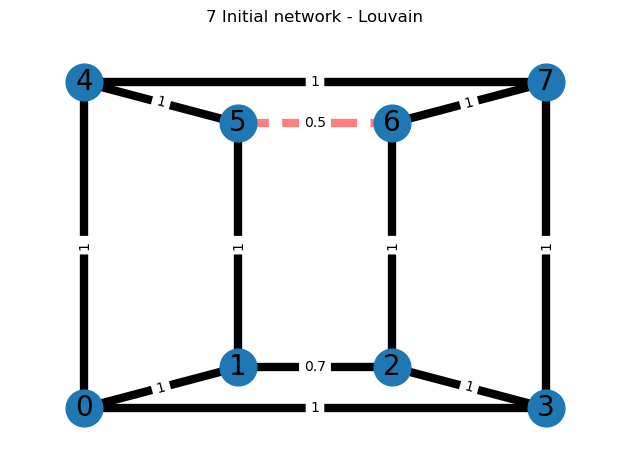

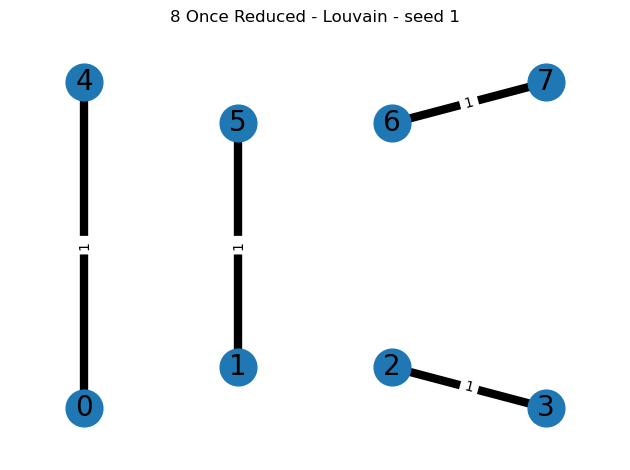

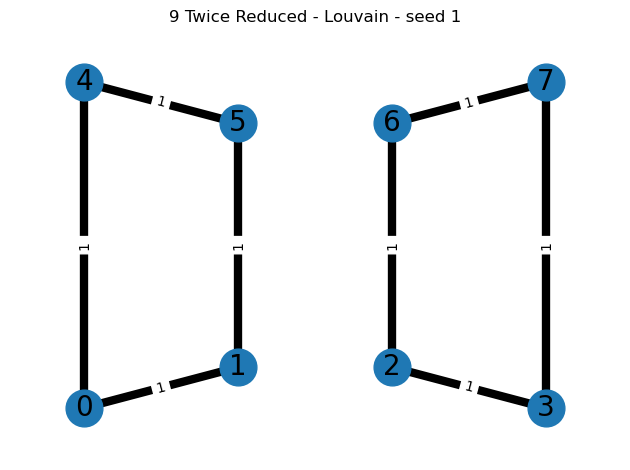

In [124]:
###################################
## Define Functions for Figure 2 ##
###################################
def remove_intercommunity_edges(G, communities):
    """
    Removes all edges between communities in the graph G.

    Parameters:
    - G: A NetworkX graph (can be directed or undirected)
    - communities: A list of sets, each set contains nodes in one community
                   (e.g., output of nx.community.louvain_communities)

    Returns:
    - G_sub: A copy of G with only intra-community edges retained
    """
    # Create a copy to avoid modifying the original graph
    G_sub = G.copy()
    
    # Build a node to community index map
    node_to_comm = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            node_to_comm[node] = idx

    # Identify and remove inter-community edges
    edges_to_remove = []
    for u, v in G.edges():
        if node_to_comm.get(u) != node_to_comm.get(v):
            edges_to_remove.append((u, v))

    G_sub.remove_edges_from(edges_to_remove)
    return G_sub


###############################
###### Louvain algorithm ######
###############################
# Make graph ()
myNeighborNetwork1 = NeighborNetwork(size=(2,4))
myNeighborNetwork2 = NeighborNetwork(size=(2,4))

## Change edge attributes
myNeighborNetwork1.G.edges[5,6]['weight'] = .5
myNeighborNetwork1.G.edges[1,2]['weight'] = .7
myNeighborNetwork2.G.edges[5,6]['weight'] = .5
myNeighborNetwork2.G.edges[1,2]['weight'] = .7

## Find communities
seed = 1
commL1 = nx.community.louvain_communities(myNeighborNetwork1.G, weight='weight', threshold=.9, max_level=100, seed=seed)
commL2 = nx.community.louvain_communities(myNeighborNetwork2.G, weight='weight', threshold=.2, max_level=100, seed=seed)

## Find Louvain communities
modularity1 = nx.community.modularity(myNeighborNetwork1.G, commL1, weight='weight')
modularity2 = nx.community.modularity(myNeighborNetwork2.G, commL2, weight='weight')

# Plot graph - Initial graph
myNeighborNetwork1.plot(title='7 Initial network - Louvain', saveFig=True)

# Plot graph - Once reduced
## Removed all edge connections and add them where there are nodes forming communities
myNeighborNetwork1.G = remove_intercommunity_edges(myNeighborNetwork1.G, commL1)
## Plot
myNeighborNetwork1.plot(title='8 Once Reduced - Louvain - seed {}'.format(seed), saveFig=True)

# # Plot graph - Twice reduced
## Removed inter-community connections
myNeighborNetwork2.G = remove_intercommunity_edges(myNeighborNetwork2.G, commL2)
## Plot
myNeighborNetwork2.plot(title='9 Twice Reduced - Louvain - seed {}'.format(seed), saveFig=True)


# Figure 3: (Leiden Ensemble - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 12
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden_5

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4298.14it/s]


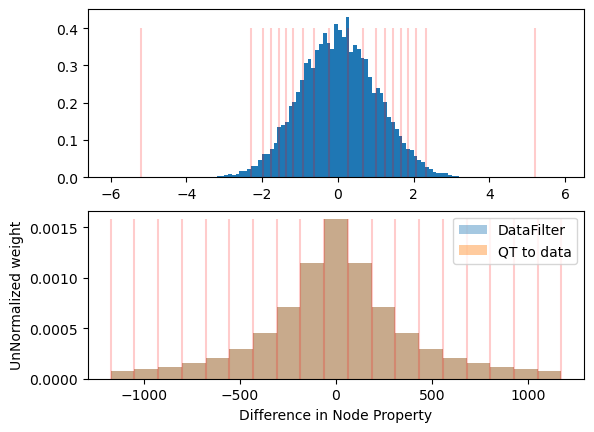

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:30<00:00, 797.95it/s]


len(LDcommunities) 93
Network has been overwritten.


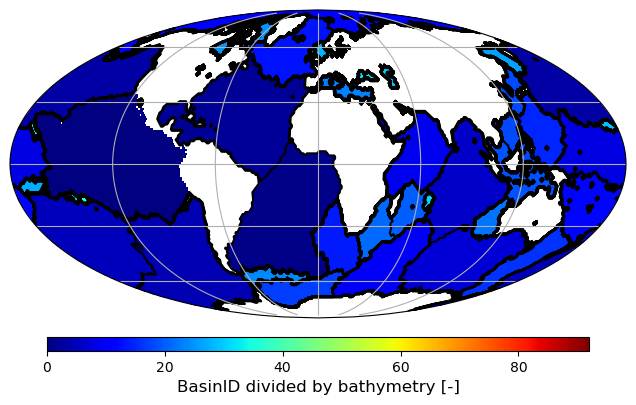

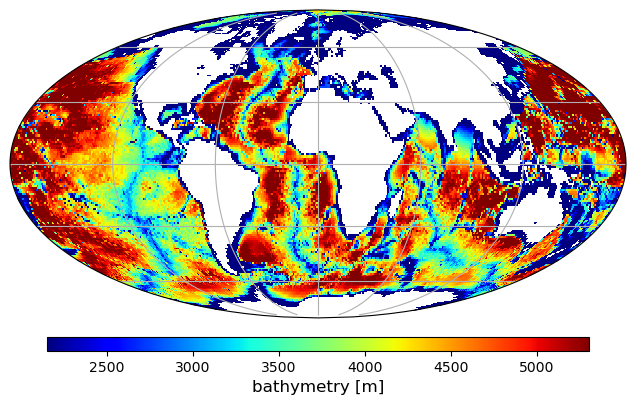

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
# Options:
#     "Louvain", "Louvain-Girvan-Newman",
#     "Leiden", "Leiden-Girvan-Newman"
communityDetectionMethod = "Leiden"


# Define basin merging criteria
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];

# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


In [20]:
# Create nodeclustering object
from cdlib import evaluation
from cdlib import NodeClustering

cluster=NodeClustering(communities=basins.Lcommunities,
                       graph=basins.G,
                       method_name="consensus_louvain_fixed",
                       method_parameters={
                           "resolution_parameter": resolution,
                           "runs": ensembleSize,
                           "distance_threshold": 0.3}
                      )


# Modularity (default objective of Louvain/Leiden)
newman_girvan_modularity = evaluation.newman_girvan_modularity(basins.G, cluster)

# Complementary measures
internal_edge_density = evaluation.internal_edge_density(basins.G, cluster)
erdos_renyi_modularity= evaluation.erdos_renyi_modularity(basins.G, cluster)
modularity_density    = evaluation.modularity_density(basins.G, cluster)
avg_embeddedness      = evaluation.avg_embeddedness(basins.G, cluster)
conductance           = evaluation.conductance(basins.G, cluster)
surprise              = evaluation.surprise(basins.G, cluster)
significance          = evaluation.significance(basins.G, cluster)

print("For Louvain: ")
print("newman_girvan_modularity:\t ", newman_girvan_modularity)
print("erdos_renyi_modularity:\t\t ", erdos_renyi_modularity)
print("modularity_density:\t\t ", modularity_density)
print("internal_edge_density:\t\t ", internal_edge_density)
print("avg_embeddedness:\t\t ", avg_embeddedness)
print("conductance:\t\t\t ", conductance)
print("surprise:\t\t\t ", surprise)
print("significance:\t\t\t ", significance)


For Louvain: 
newman_girvan_modularity:	  FitnessResult(min=None, max=None, score=0.9030815011327591, std=None)
erdos_renyi_modularity:		  FitnessResult(min=None, max=None, score=0.904670604964668, std=None)
modularity_density:		  FitnessResult(min=None, max=None, score=127.32847620536495, std=None)
internal_edge_density:		  FitnessResult(min=0, max=1.0, score=0.13735810712572588, std=0.2690833836318604)
avg_embeddedness:		  FitnessResult(min=0.0, max=1.0, score=0.8896184586792197, std=0.18948760962130792)
conductance:			  FitnessResult(min=0.0, max=1.0, score=0.07224492431104372, std=0.16206205529834894)
surprise:			  FitnessResult(min=None, max=None, score=119519.60968621375, std=None)
significance:			  FitnessResult(min=None, max=None, score=nan, std=None)


In [12]:
# Create nodeclustering object
from cdlib import evaluation
from cdlib import NodeClustering

cluster=NodeClustering(communities=basins.LDcommunities,
                       graph=basins.G,
                       method_name="consensus_leiden_fixed",
                       method_parameters={
                           "resolution_parameter": resolution,
                           "runs": ensembleSize,
                           "distance_threshold": 0.3}
                      )


# Modularity (default objective of Louvain/Leiden)
newman_girvan_modularity = evaluation.newman_girvan_modularity(basins.G, cluster)

# Complementary measures
internal_edge_density = evaluation.internal_edge_density(basins.G, cluster)
erdos_renyi_modularity= evaluation.erdos_renyi_modularity(basins.G, cluster)
modularity_density    = evaluation.modularity_density(basins.G, cluster, lmbd=0.5)
avg_embeddedness      = evaluation.avg_embeddedness(basins.G, cluster)
conductance           = evaluation.conductance(basins.G, cluster)
surprise              = evaluation.surprise(basins.G, cluster)
significance          = evaluation.significance(basins.G, cluster)

print("For Leiden: ")
print("newman_girvan_modularity:\t ", newman_girvan_modularity)
print("erdos_renyi_modularity:\t\t ", erdos_renyi_modularity)
print("modularity_density:\t\t ", modularity_density)
print("internal_edge_density:\t\t ", internal_edge_density)
print("avg_embeddedness:\t\t ", avg_embeddedness)
print("conductance:\t\t\t ", conductance)
print("surprise:\t\t\t ", surprise)
print("significance:\t\t\t ", significance)


For Leiden: 
newman_girvan_modularity:	  FitnessResult(min=None, max=None, score=0.9053231620120261, std=None)
erdos_renyi_modularity:		  FitnessResult(min=None, max=None, score=0.9069637683189091, std=None)
modularity_density:		  FitnessResult(min=None, max=None, score=112.33315312833008, std=None)
internal_edge_density:		  FitnessResult(min=0.0, max=1.0, score=0.14552194015861855, std=0.26655141336481)
avg_embeddedness:		  FitnessResult(min=0.0, max=1.0, score=0.8015361940181349, std=0.2992535176600357)
conductance:			  FitnessResult(min=0.0, max=1.0, score=0.1371089191531931, std=0.26510500301328066)
surprise:			  FitnessResult(min=None, max=None, score=120793.16851519697, std=None)
significance:			  FitnessResult(min=None, max=None, score=nan, std=None)


In [8]:
import numpy as np

louvain = np.array( [0.9030815011327591, 0.904670604964668, 127.32847620536495,
                     0.13735810712572588, 0.8896184586792197, 0.07224492431104372,
                     119519.60968621375]
                  )


Leiden = np.array(  [0.9053231620120261, 0.9069637683189091, 112.33315312833008,
                     0.14552194015861855, 0.8015361940181349, 0.1371089191531931,
                     120793.16851519697]
                 )

metrics = ["newman_girvan_modularity:\t ", "erdos_renyi_modularity:\t ",
           "modularity_density:\t\t ", "internal_edge_density:\t ",
           "avg_embeddedness:\t\t ", "conductance:\t\t\t ",
           "surprise:\t\t\t "
          ]
for i in range(len(metrics)):
    print("Louvain to Leiden: {0} increased by {1:0.2f} %".format(metrics[i], 100*(Leiden[i]-louvain[i])/louvain[i]))


Louvain to Leiden: newman_girvan_modularity:	  increased by 0.25 %
Louvain to Leiden: erdos_renyi_modularity:	  increased by 0.25 %
Louvain to Leiden: modularity_density:		  increased by -11.78 %
Louvain to Leiden: internal_edge_density:	  increased by 5.94 %
Louvain to Leiden: avg_embeddedness:		  increased by -9.90 %
Louvain to Leiden: conductance:			  increased by 89.78 %
Louvain to Leiden: surprise:			  increased by 1.07 %


erdos_renyi_modularity:
- Measures how many edges are inside communities compared to a uniform-random benchmark.
- Use when your null hypothesis is one of pure randomness, not degree-driven structure.
- Helpful to reveal community structure that stands out from homogeneous randomness.

modularity_density:
- Degree difference focus: By comparing internal vs external degrees at a per-node level, the measure highlights tightly-knit communities.
- Parameter tuning via λ: Changing λ adjusts the weighting between promoting internal cohesion vs penalizing external connections.

internal_edge_density:
- Direct measure of cohesion: tells you how internally dense each community is—ideal for spotting loosely connected clusters.
- Normalization for size: by dividing by the total possible internal edges, it avoids bias—small groups need full connectivity to score 1, while larger ones are compared fairly.

avg_embeddedness:
- Cohesion insight: Embeddedness shows how “inside-focused” nodes are in their communities.
- Node-level granularity: Unlike global density, this highlights nodes with many external connections.
- Community health: Low average embeddedness suggests porous boundaries or weak community structure.


# Figure 3: (Girvan-Newman - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 11
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden_1

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4329.01it/s]


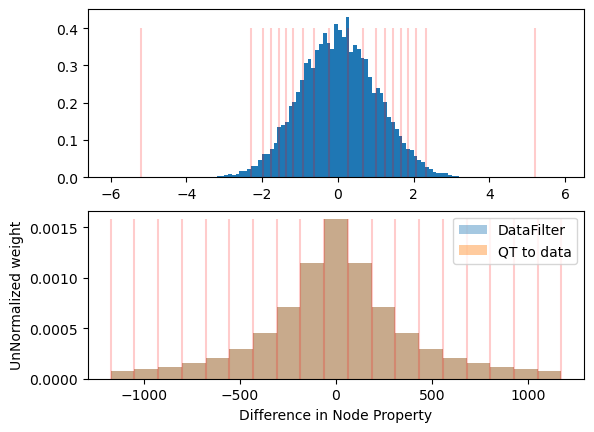

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:30<00:00, 813.38it/s]


Louvain Communities (93), Target (56), Isolated Communities 45
Time: -0.0009219646453857422 seconds
Time: -1.430511474609375e-06 seconds
Time: -0.11057734489440918 seconds
Time: -5.7220458984375e-06 seconds
Time: -0.00018644332885742188 seconds
Network has been overwritten.


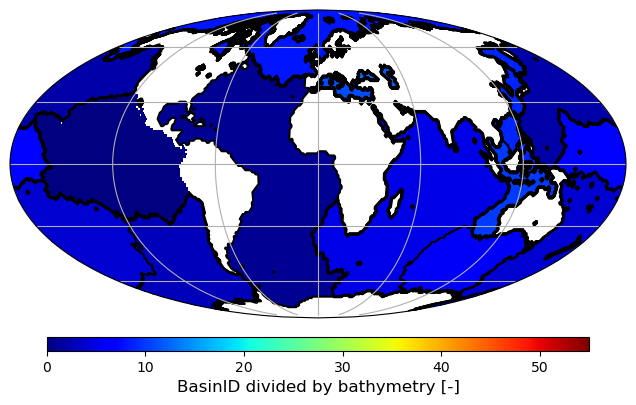

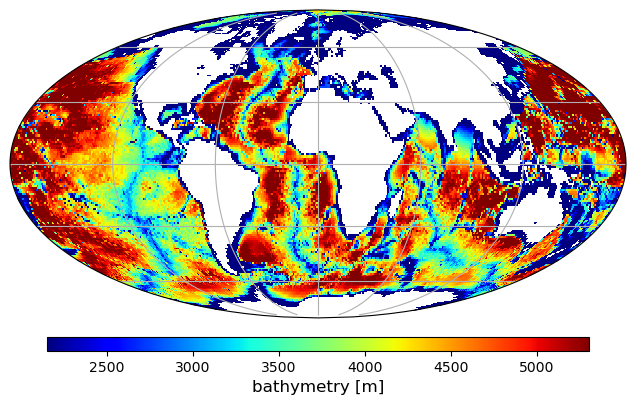

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
# Options:
#     "Louvain", "Louvain-Girvan-Newman",
#     "Leiden", "Leiden-Girvan-Newman"
communityDetectionMethod = "Leiden-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [11]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


# Figure 3: (Small-Community - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 11
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden_2

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4289.78it/s]


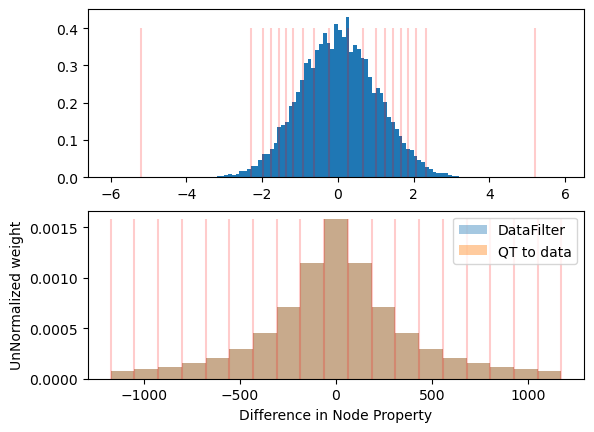

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:30<00:00, 796.98it/s]


Louvain Communities (93), Target (56), Isolated Communities 45
Time: -0.000911712646484375 seconds
Time: -1.430511474609375e-06 seconds
Time: -0.10928845405578613 seconds
Time: -5.7220458984375e-06 seconds
Time: -0.0001957416534423828 seconds
Network has been overwritten.
Network has been overwritten.


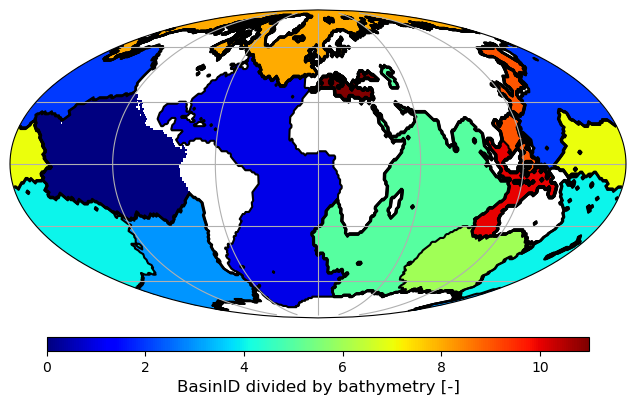

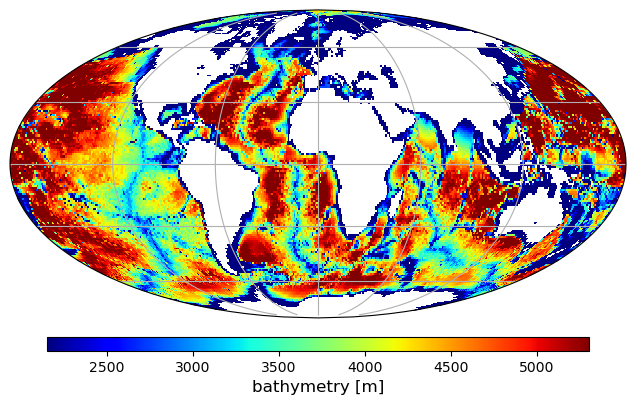

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
# Options:
#     "Louvain", "Louvain-Girvan-Newman",
#     "Leiden", "Leiden-Girvan-Newman"
communityDetectionMethod = "Leiden-Girvan-Newman"


# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [11]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}


    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_Leiden')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


# Figure 3: (Graph network nodes-edges)
Plot 1: Input network with 1 degree resolution

Plot 2: Louvain or Leiden node reduction community detection (depends on which above cells were run)

Storing images in figures/CommunityDetectionMethodsPaper/CommunityReductionDiagrams_Leiden_0


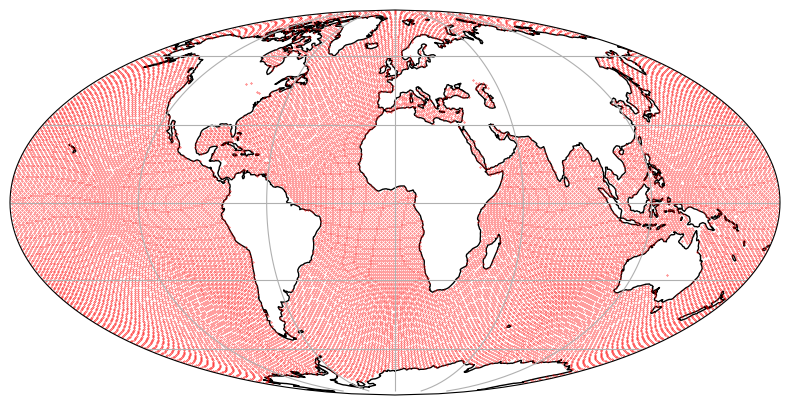

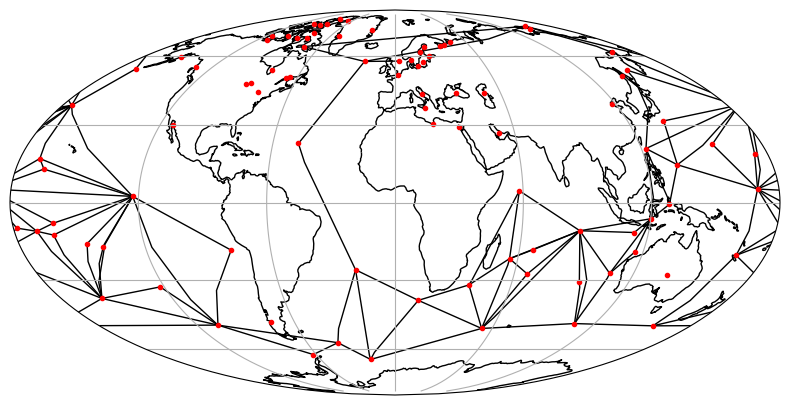

In [4]:
# Create node plot:
#     1) Base 1 degree resolution
#     2) Louvain community nodes (i.e., input to Girvan-Newman)
#
####################################################
### Define functions for plotting graph networks ###
####################################################
def split_antimeridian_line(lon1, lat1, lon2, lat2):
    """
    Split a line crossing the antimeridian into two segments,
    one in the eastern hemisphere and one in the western.

    Returns:
        western_segment: ((lon_a, lat_a), (lon_b, lat_b)) or None
        eastern_segment: ((lon_c, lat_c), (lon_d, lat_d)) or None
    """
    # Normalize longitudes to [-180, 180]
    lon1 = (lon1 + 180) % 360 - 180
    lon2 = (lon2 + 180) % 360 - 180

    if abs(lon2 - lon1) <= 180:
        # No crossing: return the full segment and None for the other
        if lon1 < 0:
            return ((lon1, lat1), (lon2, lat2)), None
        else:
            return None, ((lon1, lat1), (lon2, lat2))

    # Antimeridian crossing
    # Determine direction of crossing
    if lon1 > lon2:
        lon2 += 360
    else:
        lon1 += 360

    # Interpolation factor for crossing at 180°
    frac = (180 - lon1) / (lon2 - lon1)
    lat_mid = lat1 + frac * (lat2 - lat1)

    # First segment: lon1 -> 180°
    western_segment = ((lon1, lat1), (180, lat_mid))
    # Second segment: -180° -> lon2
    eastern_segment = ((180, lat_mid), (lon2, lat2))

    return western_segment, eastern_segment

def plotNodes(G, latitude, longitude,
              drawEdges=False, showSideEdges=True,
              markersize =.3,
              fidName='test.png', savePNG=False, saveSVG=False):
    
    # Imports
    import cartopy.crs as ccrs # type: ignore
    # Plot the network on a geographic map
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.Mollweide()})
    ax.set_global()

    # Draw the edges (connections)
    if drawEdges:
        for edge in G.edges(data=True):
            node1, node2, weight = edge
            lon1, lat1 = longitude[node1], latitude[node1]
            lon2, lat2 = longitude[node2], latitude[node2]
            cutoff = 90;
            if ((lon2<-cutoff) & (lon1>cutoff)) | ((lon1<-cutoff) & (lon2>cutoff)):
                # Node connection passes through antimeridian
                if showSideEdges:
                    #lats, lons = split_antimeridian([lon1, lon2], [lat1, lat2])
                    segment1, segment2 = split_antimeridian_line(lon1, lat1, lon2, lat2)
                    ax.plot([segment1[0][0],segment1[1][0]], [segment1[0][1],segment1[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                    ax.plot([segment2[0][0],segment2[1][0]], [segment2[0][1],segment2[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                pass
            else:
                # Node connection does not pass through antimeridian
                ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1, transform=ccrs.PlateCarree())
            
            
    # Draw the nodes (points) on the map
    ax.plot(longitude, latitude, 'ro', markersize=markersize, transform=ccrs.PlateCarree())  # longitude, latitude

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()

    #plt.title("Geographic Network of points")
    
    # Save figure
    if savePNG:
        plt.savefig(fidName, dpi=600, transparent=True)
    if saveSVG:
        plt.savefig(fidName.replace(".png", ".svg"))

        
######################################
# Add details of community reduction #
######################################
        
# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CommunityReductionDiagrams_Leiden')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

###############################
# 1) Base 1 degree resolution #
###############################
# Define node locations (latitude/longitude)
baseNodesLat = np.array([],dtype=float);
baseNodesLon = np.array([],dtype=float);
for x in basins.G:
    baseNodesLat = np.append(baseNodesLat, basins.G.nodes[x]['pos'][0])
    baseNodesLon = np.append(baseNodesLon, basins.G.nodes[x]['pos'][1])


plotNodes(basins.G, baseNodesLat, baseNodesLon,
          drawEdges=False, showSideEdges=False,
          fidName=fldName+'/BaseNodes.png',
          savePNG=True)


#############################################################
# 2) Louvain community nodes (i.e., input to Girvan-Newman) #
#############################################################
import copy as cp
LNodesLat = np.array([],dtype=float);
LNodesLon = np.array([],dtype=float);

for x in basins.Gnew:
    # Set nodes idx that are compiled into new nodes for
    # girvan-newman algorithm
    nodesInGnew = np.array(list(basins.LDcommunities[x]), dtype=np.int32)
    # Set average latitude and longitude of nodes in louvain community
    cutoff = 90;
    if (np.min(baseNodesLon[nodesInGnew])<-cutoff) & (np.max(baseNodesLon[nodesInGnew])>cutoff):
        # At the -180,180 boundary find the mean latitude/longitude
        # A mean is fine since nodes represent equal area quadrangles.
        Lons = cp.deepcopy(baseNodesLon[nodesInGnew]);
        Lons[Lons<0] += 360;
        aveLon = np.mean(Lons)
        if aveLon>180:
            aveLon -=360;
    else:
        aveLon = np.mean(baseNodesLon[nodesInGnew])
    
    LNodesLat = np.append(LNodesLat, np.mean(baseNodesLat[nodesInGnew]) )
    LNodesLon = np.append(LNodesLon, aveLon )


#########################
### Plot input fields ###
#########################
plotNodes(basins.Gnew, LNodesLat, LNodesLon,
          drawEdges=True, showSideEdges=True,
          markersize =3,
          fidName=fldName+'/LeidenCommunityNodes.png',
          savePNG=True)



# Figure 3-alternative: (Louvain - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:8649: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4362.27it/s]


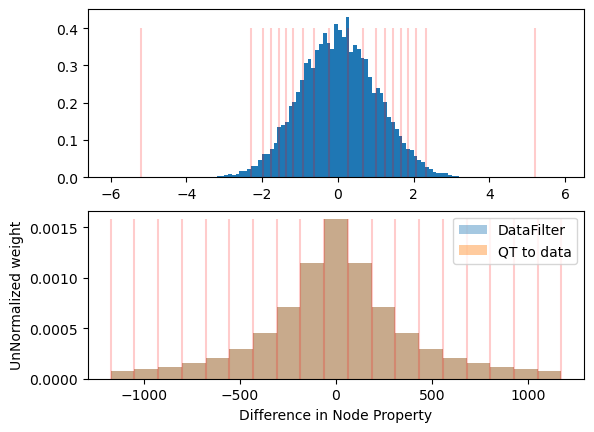

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:30<00:00, 811.65it/s]


Network has been overwritten.


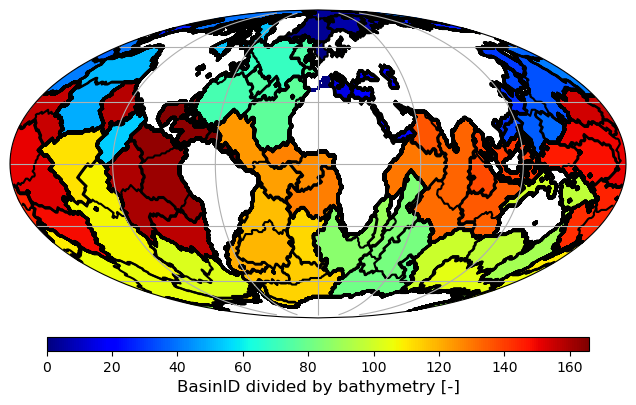

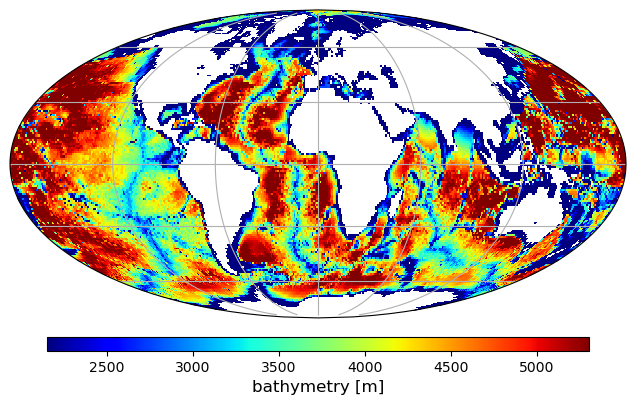

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
communityDetectionMethod = "Louvain"
#communityDetectionMethod = "Louvain-Girvan-Newman"

# Define basin merging criteria
#mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
resolution = 1; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
detectionMethod = {"method":communityDetectionMethod,
                   "resolution":resolution,
                   "minBasinCnt":-2,
                   "minBasinLargerThanSmallMergers":False,
                   "mergerPackage":mergerPackage}

# Set the edge weight scheme for node connections
# Options:
#    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
#    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
#    "useQTGaussianShiftedGaussianWeightDistribution"
edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                   "shortenFactor": 3,
                   "shiftFactor": 1,
                   "minWeight": 0.01}
# edgeWeightMethod = {"method":"useLogistic"}





# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

    
#################################################################
### Create basin object and set Field for Community detection ###
#################################################################

# Create basin object
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);


# Assign fields to use in community detection
basins.useFields(fieldList=np.array(["Field1"]))

# Show all fields stored in basins object
basins.getFields(usedFields = False)

# Show all fields stored in basins object that will be used
# for community detection.
basins.getFields(usedFields = True)


#########################################
### Run Community Detection Algorithm ###
#########################################

# Define basins based on user input boundaries.
# For the Louvain-Girvan-Newman composite algorithm the variable
# minBasinCnt refers to the number of basins to maintain that are
# not completely isolated after running the louvain algorithm.
basins.defineBasins(detectionMethod = detectionMethod,
                    edgeWeightMethod = edgeWeightMethod,
                    reducedRes={"on":True,"factor":1},
                    read=False,
                    write=True,
                    verbose=False)


# Merge communities based off criteria 
basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

# Convert basinID equal area grid to regular grid
basins.interp2regularGrid(mask=True)


#####################################
### Plot results of community IDs ###
#####################################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                    pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "plotIntegerContours":True,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)

# Calculate area weighted average and standard deviation (for plotting)
areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                          LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                          LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

#########################
### Plot input fields ###
#########################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[ave-1*std,
                                            ave+1*std]},
                    pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)


# Figure 3-alternative: (Girvan-Newman - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_3

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:8649: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|███████████████████████████████████| 24441/24441 [00:05<00:00, 4369.82it/s]


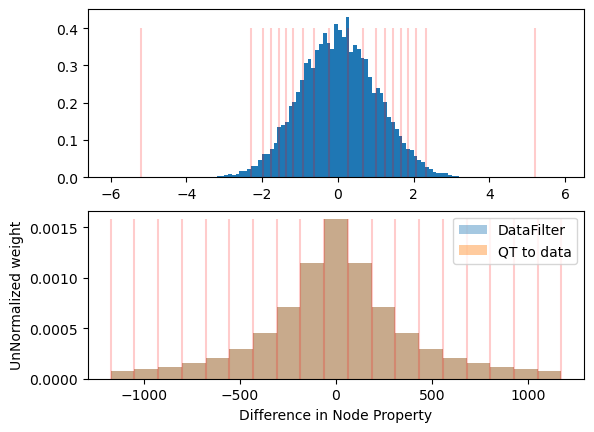

100%|████████████████████████████████████| 24441/24441 [00:30<00:00, 797.60it/s]




communityCnt 48


Network has been overwritten.


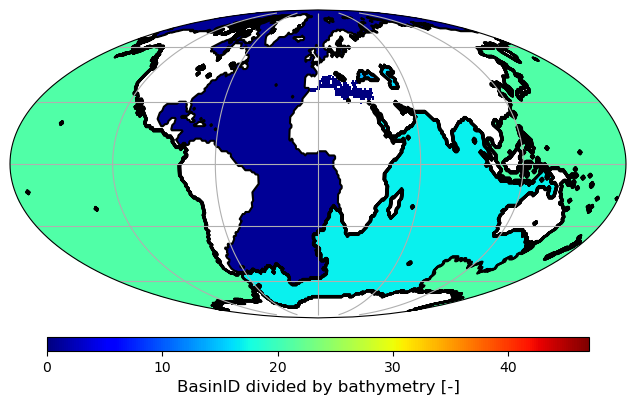

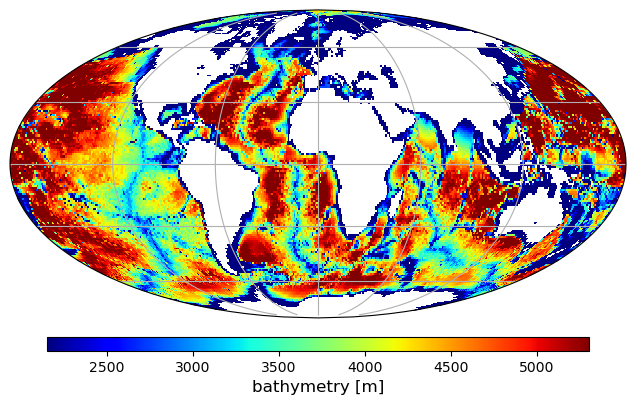

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
communityDetectionMethod = "Louvain-Girvan-Newman"

# Define basin merging criteria
#mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
resolution = 1; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
detectionMethod = {"method":communityDetectionMethod,
                   "resolution":resolution,
                   "minBasinCnt":-2,
                   "minBasinLargerThanSmallMergers":False,
                   "mergerPackage":mergerPackage}

# Set the edge weight scheme for node connections
# Options:
#    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
#    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
#    "useQTGaussianShiftedGaussianWeightDistribution"
edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                   "shortenFactor": 3,
                   "shiftFactor": 1,
                   "minWeight": 0.01}
# edgeWeightMethod = {"method":"useLogistic"}





# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

    
#################################################################
### Create basin object and set Field for Community detection ###
#################################################################

# Create basin object
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);


# Assign fields to use in community detection
basins.useFields(fieldList=np.array(["Field1"]))

# Show all fields stored in basins object
basins.getFields(usedFields = False)

# Show all fields stored in basins object that will be used
# for community detection.
basins.getFields(usedFields = True)


#########################################
### Run Community Detection Algorithm ###
#########################################

# Define basins based on user input boundaries.
# For the Louvain-Girvan-Newman composite algorithm the variable
# minBasinCnt refers to the number of basins to maintain that are
# not completely isolated after running the louvain algorithm.
basins.defineBasins(detectionMethod = detectionMethod,
                    edgeWeightMethod = edgeWeightMethod,
                    reducedRes={"on":True,"factor":1},
                    read=False,
                    write=True,
                    verbose=False)


# Merge communities based off criteria 
basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

# Convert basinID equal area grid to regular grid
basins.interp2regularGrid(mask=True)


#####################################
### Plot results of community IDs ###
#####################################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                    pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "plotIntegerContours":True,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)

# Calculate area weighted average and standard deviation (for plotting)
areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                          LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                          LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

#########################
### Plot input fields ###
#########################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[ave-1*std,
                                            ave+1*std]},
                    pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)


# Figure 3-alternative: (Small-Community - Reduction) 
Makes of bathymetry dependent community detection plots for figure 3 of manuscript.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_3

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:8746: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


sh: 1: temp.txt: not found
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4265.77it/s]


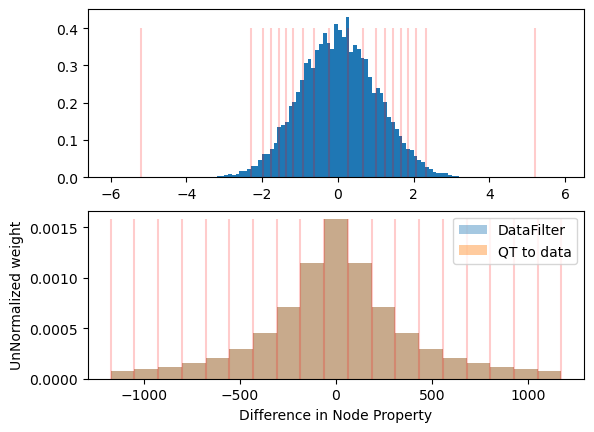

 37%|███████████████████████████████████████████████████████████▋                                                                                                       | 8955/24441 [00:11<00:19, 786.93it/s]


KeyboardInterrupt: 

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
communityDetectionMethod = "Louvain-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
#mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
resolution = 1; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
detectionMethod = {"method":communityDetectionMethod,
                   "resolution":resolution,
                   "minBasinCnt":-2,
                   "minBasinLargerThanSmallMergers":False,
                   "mergerPackage":mergerPackage}

# Set the edge weight scheme for node connections
# Options:
#    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
#    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
#    "useQTGaussianShiftedGaussianWeightDistribution"
edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                   "shortenFactor": 3,
                   "shiftFactor": 1,
                   "minWeight": 0.01}
# edgeWeightMethod = {"method":"useLogistic"}





# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

    
#################################################################
### Create basin object and set Field for Community detection ###
#################################################################

# Create basin object
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);


# Assign fields to use in community detection
basins.useFields(fieldList=np.array(["Field1"]))

# Show all fields stored in basins object
basins.getFields(usedFields = False)

# Show all fields stored in basins object that will be used
# for community detection.
basins.getFields(usedFields = True)


#########################################
### Run Community Detection Algorithm ###
#########################################

# Define basins based on user input boundaries.
# For the Louvain-Girvan-Newman composite algorithm the variable
# minBasinCnt refers to the number of basins to maintain that are
# not completely isolated after running the louvain algorithm.
basins.defineBasins(detectionMethod = detectionMethod,
                    edgeWeightMethod = edgeWeightMethod,
                    reducedRes={"on":True,"factor":1},
                    read=False,
                    write=True,
                    verbose=False)


# Merge communities based off criteria 
basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

# Convert basinID equal area grid to regular grid
basins.interp2regularGrid(mask=True)


#####################################
### Plot results of community IDs ###
#####################################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                    pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "plotIntegerContours":True,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)

# Calculate area weighted average and standard deviation (for plotting)
areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                          LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                          LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

#########################
### Plot input fields ###
#########################
EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[ave-1*std,
                                            ave+1*std]},
                    pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "transparent":True},
                    savePNG=True,
                    saveSVG=False)


### Plots of difference data / 

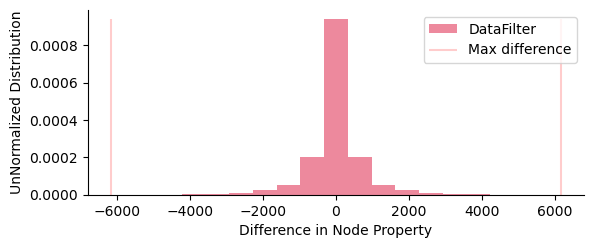

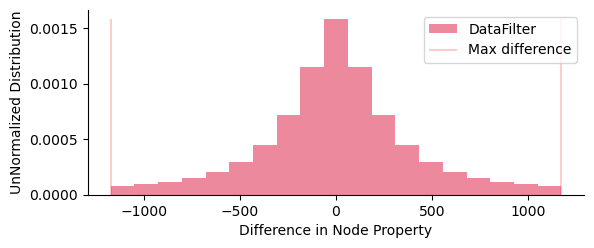

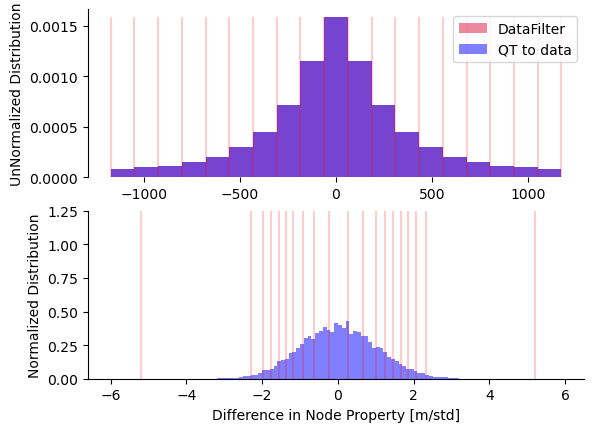

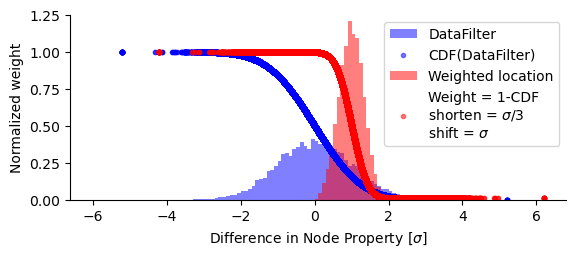

In [62]:
def createDataTreatmentFigures(basins, field,
                               RawDiff=True, IQRFilter=True,  QT=True, QT_CDF=True,
                               savePNG=False, saveSVG=False, directory=os.getcwd()):
    """
    createDataTreatmentFigures create figures to
    visualize the data treatment process in making
    graph edge weights.
    
    Parameters
    -----------
    RawDiff : BOOLEAN
        Plot a distribution of the raw differences
        between connected nodes within the graph.
    IQRFilter : BOOLEAN
        Plot a distribution of the IQR filtered
        differences between connected nodes within
        the graph.
    QT : BOOLEAN
        Plot a distribution of the IQR filtered
        and QT distributed differences between
        connected nodes within the graph.
    QT_CDF : BOOLEAN
        Plot a distribution of the QT distributed
        differences between connected nodes within
        the graph, with a overlay of the CDF function
        used to determine node edge weights.
    savePNG : BOOLEAN
        An option to plot PNGs.
    saveSVG : BOOLEAN
        An option to plot SVGs.
    directory : STRING
        An output directory for the saved figures.
    
    """
    # Set a directory / general name for figure naming convention.
    fidName = basins.Fields[field]['parameterName']
    
    ###################################
    ############# Imports #############
    ###################################
    from scipy.stats import norm
    from sklearn.preprocessing import QuantileTransformer
    
    
    ###################################
    ########## Create figures #########
    ###################################
    if RawDiff:
        # Define mirrored difference data
        xValues = np.append(basins.Fields[field]['dataEdgeDiff'], -basins.Fields[field]['dataEdgeDiff'])
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        
        # Plot subplot
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        # Compare original vs QT 
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='DataFilter', density=True)
        plt.vlines(x=[np.min(xValues), np.max(xValues)],
                   ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2,
                   label='Max difference')
        
        # Formatting
        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property");
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        
        # Save figure
        if savePNG:
            plt.savefig(directory+"RawDiff_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"RawDiff_{}.svg".format(fidName))
        
        
    if IQRFilter:
        # Define mirrored difference data
        xValues = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        
        # Plot subplot
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        # Compare original vs QT 
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='DataFilter', density=True)
        plt.vlines(x=[np.min(xValues), np.max(xValues)],
                   ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2,
                   label='Max difference')
        
        # Formatting
        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property");
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        
        # Save figure
        if savePNG:
            plt.savefig(directory+"IQRFilter_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"IQRFilter_{}.svg".format(fidName))

        
    if QT:
        xValues = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        basins.Fields[field]['weightMethodPara']['qt'] = \
        QuantileTransformer(n_quantiles=1000,
                            random_state=0,
                            output_distribution='normal')
        qtDiss  = basins.Fields[field]['weightMethodPara']['qt'].fit_transform(np.reshape(xValues, (len(xValues),1)))

        # Create a set of equal space values in the data domain
        # These can be plotted on the gaussian domain to see the data stretching
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        binsqt = basins.Fields[field]['weightMethodPara']['qt'].transform(np.reshape(bins, (len(bins),1)))

        # Plot subplot
        fig, axes = plt.subplots(nrows=2, ncols=1);
        # QT distribution
        plt.sca(axes[1])
        plt.hist(qtDiss, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DataFilter', density=True)
        plt.vlines(x=binsqt, ymin=0, ymax=1.25, colors='r', alpha=.2)

        # Compare original vs QT 
        plt.sca(axes[0])
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='DataFilter', density=True)
        plt.vlines(x=bins, ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2)
        qtxValues = basins.Fields[field]['weightMethodPara']['qt'].inverse_transform(qtDiss)
        plt.hist(qtxValues, alpha=.5, color='b', bins=bins, label='QT to data', density=True);

        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.sca(axes[1])
        plt.ylim([0,1.25])
        plt.ylabel("Normalized Distribution")
        plt.xlabel("Difference in Node Property [{}/std]".format(basins.Fields[field]['parameterUnit']));
        
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        
        # Save figure
        if savePNG:
            plt.savefig(directory+"QT_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"QT_{}.svg".format(fidName))
        
        
    if QT_CDF:
        # Set data as IQRFiltered that is mirrored on the at dataEdgeDiffIQRFiltered=0
        # (no difference in adjacent node values)
        xValuesFiltered = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'],
                                    -basins.Fields[field]['dataEdgeDiffIQRFiltered'])

        # Create QT object and fit
        qt = QuantileTransformer(n_quantiles=1000, random_state=0,  output_distribution='normal')
        x  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

        # Use the QT to convert the xValuesFiltered difference data into z-score space. 
        xFiltered  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

        # Define the cumulative density function in the z-score space. 
        stretchFactor = 3;
        qtDissSTD = 1
        cdfCenter  = qtDissSTD*1
        cdfStretch = qtDissSTD/stretchFactor
        normCDF = 1-1*norm.cdf(xFiltered, loc=0, scale=cdfStretch)
        normCDF2 = 1-1*norm.cdf(xFiltered, loc=0, scale=1)

        distribution = norm.ppf(normCDF.T[0], loc=cdfCenter, scale=cdfStretch/stretchFactor)


        ################################
        ############# Plot #############
        ################################
        # Plot subplot
        #fig, axes = plt.subplots(nrows=1, ncols=1);
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        
        # QT distribution
        plt.sca(axes)

        plt.hist(xFiltered, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DataFilter', density=True);
        plt.plot(xFiltered, normCDF2.T[0], 'b.',  alpha=.5, label='CDF(DataFilter)');

        minWeight = 0.01;
        plt.hist(distribution, alpha=.5, color='r', bins=np.arange(-6, 6, .1), label='Weighted location', density=True);
        plt.plot(xFiltered+cdfCenter, (normCDF.T[0]+minWeight)/(1+minWeight), 'r.',  alpha=.5,
                 label='Weight = 1-CDF\nshorten = $\sigma/{}$\nshift = $\sigma$'.format(stretchFactor));

        # Formatting
        plt.legend();
        plt.xlabel(r"Difference in Node Property $[\sigma]$");
        plt.ylabel("Normalized weight")
        plt.ylim([0,1.25])
        #plt.title(r"Example: QT-Gaussian (Z-Score-Space); Weight by CDF");
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)

        # Save figure
        if savePNG:
            plt.savefig(directory+"QT_CDF_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"QT_CDF_{}.svg".format(fidName))

        
        
        
        
        
        
        
        
        
        
        

        
field = 'Field1'
createDataTreatmentFigures(basins, field,
                           RawDiff=True, IQRFilter=True,  QT=True,
                           savePNG=True, saveSVG=True,
                           directory=os.getcwd()+"/figures/CommunityDetectionMethodsPaper/EtopoDataTreatment/")



# Figure 3: (Graph network nodes-edges)
Plot 1: Input network with 1 degree resolution

Plot 2: Louvain or Leiden node reduction community detection (depends on which above cells were run)

Storing images in figures/CommunityDetectionMethodsPaper/CommunityReductionDiagrams_0


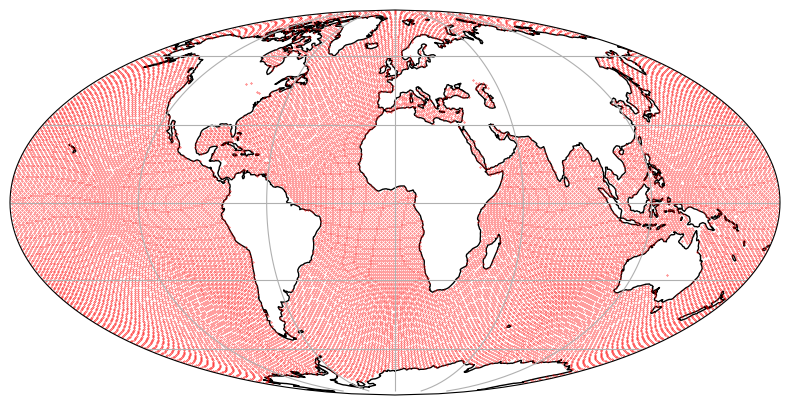

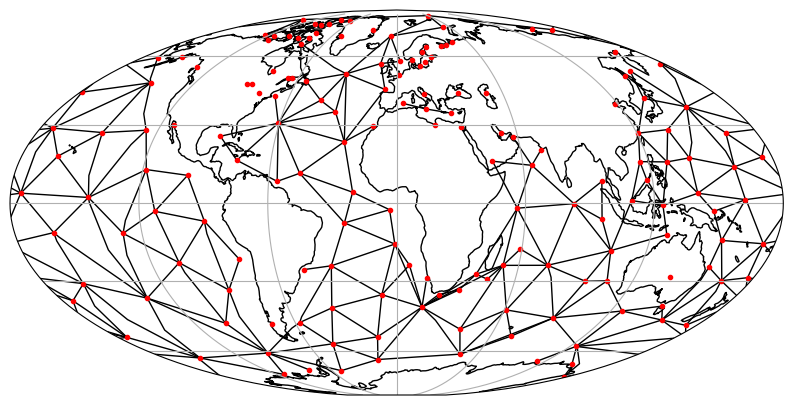

In [14]:
# Create node plot:
#     1) Base 1 degree resolution
#     2) Louvain community nodes (i.e., input to Girvan-Newman)
#
####################################################
### Define functions for plotting graph networks ###
####################################################
def split_antimeridian_line(lon1, lat1, lon2, lat2):
    """
    Split a line crossing the antimeridian into two segments,
    one in the eastern hemisphere and one in the western.

    Returns:
        western_segment: ((lon_a, lat_a), (lon_b, lat_b)) or None
        eastern_segment: ((lon_c, lat_c), (lon_d, lat_d)) or None
    """
    # Normalize longitudes to [-180, 180]
    lon1 = (lon1 + 180) % 360 - 180
    lon2 = (lon2 + 180) % 360 - 180

    if abs(lon2 - lon1) <= 180:
        # No crossing: return the full segment and None for the other
        if lon1 < 0:
            return ((lon1, lat1), (lon2, lat2)), None
        else:
            return None, ((lon1, lat1), (lon2, lat2))

    # Antimeridian crossing
    # Determine direction of crossing
    if lon1 > lon2:
        lon2 += 360
    else:
        lon1 += 360

    # Interpolation factor for crossing at 180°
    frac = (180 - lon1) / (lon2 - lon1)
    lat_mid = lat1 + frac * (lat2 - lat1)

    # First segment: lon1 -> 180°
    western_segment = ((lon1, lat1), (180, lat_mid))
    # Second segment: -180° -> lon2
    eastern_segment = ((180, lat_mid), (lon2, lat2))

    return western_segment, eastern_segment

def plotNodes(G, latitude, longitude,
              drawEdges=False, showSideEdges=True,
              markersize =.3,
              fidName='test.png', savePNG=False, saveSVG=False):
    
    # Imports
    import cartopy.crs as ccrs # type: ignore
    # Plot the network on a geographic map
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.Mollweide()})

    # Draw the edges (connections)
    if drawEdges:
        for edge in G.edges(data=True):
            node1, node2, weight = edge
            lon1, lat1 = longitude[node1], latitude[node1]
            lon2, lat2 = longitude[node2], latitude[node2]
            cutoff = 90;
            if ((lon2<-cutoff) & (lon1>cutoff)) | ((lon1<-cutoff) & (lon2>cutoff)):
                # Node connection passes through antimeridian
                if showSideEdges:
                    #lats, lons = split_antimeridian([lon1, lon2], [lat1, lat2])
                    segment1, segment2 = split_antimeridian_line(lon1, lat1, lon2, lat2)
                    ax.plot([segment1[0][0],segment1[1][0]], [segment1[0][1],segment1[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                    ax.plot([segment2[0][0],segment2[1][0]], [segment2[0][1],segment2[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                pass
            else:
                # Node connection does not pass through antimeridian
                ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1, transform=ccrs.PlateCarree())
            
            
    # Draw the nodes (points) on the map
    ax.plot(longitude, latitude, 'ro', markersize=markersize, transform=ccrs.PlateCarree())  # longitude, latitude

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()

    #plt.title("Geographic Network of points")
    
    # Save figure
    if savePNG:
        plt.savefig(fidName, dpi=600, transparent=True)
    if saveSVG:
        plt.savefig(fidName.replace(".png", ".svg"))

        
######################################
# Add details of community reduction #
######################################
        
# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CommunityReductionDiagrams')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

###############################
# 1) Base 1 degree resolution #
###############################
# Define node locations (latitude/longitude)
baseNodesLat = np.array([],dtype=float);
baseNodesLon = np.array([],dtype=float);
for x in basins.G:
    baseNodesLat = np.append(baseNodesLat, basins.G.nodes[x]['pos'][0])
    baseNodesLon = np.append(baseNodesLon, basins.G.nodes[x]['pos'][1])


plotNodes(basins.G, baseNodesLat, baseNodesLon,
          drawEdges=False, showSideEdges=False,
          fidName=fldName+'/BaseNodes.png',
          savePNG=True)


#############################################################
# 2) Louvain community nodes (i.e., input to Girvan-Newman) #
#############################################################
import copy as cp
LNodesLat = np.array([],dtype=float);
LNodesLon = np.array([],dtype=float);

for x in basins.Gnew:
    # Set nodes idx that are compiled into new nodes for
    # girvan-newman algorithm
    nodesInGnew = np.array(list(basins.Lcommunities[x]), dtype=np.int32)
    # Set average latitude and longitude of nodes in louvain community
    cutoff = 90;
    if (np.min(baseNodesLon[nodesInGnew])<-cutoff) & (np.max(baseNodesLon[nodesInGnew])>cutoff):
        # At the -180,180 boundary find the mean latitude/longitude
        # A mean is fine since nodes represent equal area quadrangles.
        Lons = cp.deepcopy(baseNodesLon[nodesInGnew]);
        Lons[Lons<0] += 360;
        aveLon = np.mean(Lons)
        if aveLon>180:
            aveLon -=360;
    else:
        aveLon = np.mean(baseNodesLon[nodesInGnew])
    
    LNodesLat = np.append(LNodesLat, np.mean(baseNodesLat[nodesInGnew]) )
    LNodesLon = np.append(LNodesLon, aveLon )


#########################
### Plot input fields ###
#########################
plotNodes(basins.Gnew, LNodesLat, LNodesLon,
          drawEdges=True, showSideEdges=True,
          markersize =3,
          fidName=fldName+'/LouvainCommunityNodes.png',
          savePNG=True)



# Figure Supplement X: 
Shows how the weighting scheme is defined using quantile transformation and cumulative density function of a shortened and shifted distribution in gaussian z-score space.

About 75.53 % of data is being weighted with non-min values
About 75.53 % of data is being weighted with non-min/max values


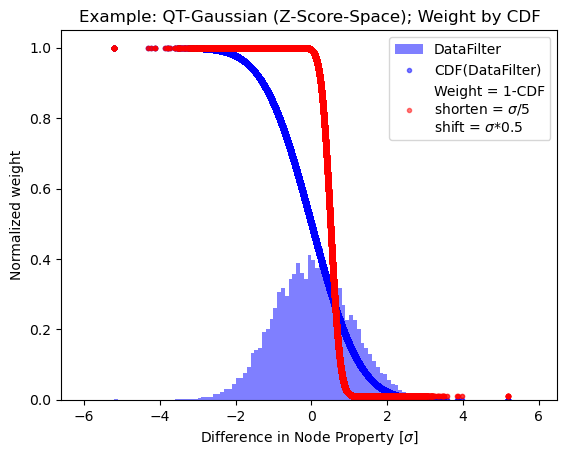

In [150]:
###################################
############# Imports #############
###################################
from scipy.stats import norm
from sklearn.preprocessing import QuantileTransformer


#########################################
############# Define QT/CDF #############
#########################################
# Set data as IQRFiltered that is mirrored on the at dataEdgeDiffIQRFiltered=0
# (no difference in adjacent node values)
xValuesFiltered = np.append(basins.Fields['Field1']['dataEdgeDiffIQRFiltered'],
                            -basins.Fields['Field1']['dataEdgeDiffIQRFiltered'])

# Create QT object and fit
qt = QuantileTransformer(n_quantiles=1000, random_state=0,  output_distribution='normal')
x  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

# Use the QT to convert the xValuesFiltered difference data into z-score space. 
xFiltered  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

# Define the cumulative density function in the z-score space. 
shortenFactor = 5;
shiftFactor = .5

qtDissSTD = 1
cdfCenter  = qtDissSTD*shiftFactor
cdfStretch = qtDissSTD/shortenFactor
normCDF = 1-1*norm.cdf(xFiltered, loc=cdfCenter, scale=cdfStretch)
normCDF2 = 1-1*norm.cdf(xFiltered, loc=0, scale=1)


################################
############# Plot #############
################################
# Plot subplot
fig, axes = plt.subplots(nrows=1, ncols=1);
# QT distribution
plt.sca(axes)

hist = plt.hist(xFiltered, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DataFilter', density=True);
plt.plot(xFiltered, normCDF2.T[0], 'b.',  alpha=.5, label='CDF(DataFilter)');

minWeight = 0.01;
#plt.hist(distribution2, alpha=.5, color='r', bins=np.arange(-6, 6, .1), label='Weighted location', density=True);
CDF_SS = (normCDF.T[0]+minWeight)/(1+minWeight);
plt.plot(xFiltered, CDF_SS, 'r.',  alpha=.5,
         label='Weight = 1-CDF\nshorten = $\sigma/{}$\nshift = $\sigma$*{}'.format(stretchFactor,shiftFactor));


plt.legend();
plt.xlabel(r"Difference in Node Property $[\sigma]$");
plt.ylabel("Normalized weight")
plt.title(r"Example: QT-Gaussian (Z-Score-Space); Weight by CDF");


# Identify what percentiles of of DataFilter are being captured with the shorten and shifted distribution
logical1 = (CDF_SS>minWeight) & (xFiltered.T[0]>=0)
logical2 = (CDF_SS>minWeight) & (CDF_SS<(1-minWeight)) & (xFiltered.T[0]>=0)
minmax_Xvalue1 = [np.min(xFiltered[logical1]), np.max(xFiltered[logical1])]
minmax_Xvalue2 = [np.min(xFiltered[logical2]), np.max(xFiltered[logical2])]

# The total percentage of data used to determine edge weights
# Multiple by 2 since the negative values are just a mirror of positive values.
percentData1 = 100*np.sum( hist[0][(hist[1][1:]>=minmax_Xvalue1[0]) & (hist[1][1:]<=minmax_Xvalue1[1])] )/np.sum(hist[0][(hist[1][1:]>=minmax_Xvalue1[0])])
percentData2 = 100*np.sum( hist[0][(hist[1][1:]>=minmax_Xvalue2[0]) & (hist[1][1:]<=minmax_Xvalue2[1])] )/np.sum(hist[0][(hist[1][1:]>=minmax_Xvalue1[0])])

print("About {:.2f} % of data is being weighted with non-min values".format(percentData1))
print("About {:.2f} % of data is being weighted with non-min/max values".format(percentData2))



# Figure 4: (Suface Community Detection with Potential Temperature and Salinity)
### Format GLORYS12V1 to be used with the ExoCcycle community detection algorithm

Create six datasets given average 1994 models/data:
1. Average deep (1000-6000m) ocean salinity
2. Average deep (1000-6000m) ocean potential temperature 
3. Average intermediate (100-1000m) ocean salinity
4. Average intermediate (100-1000m) ocean potential temperature 
5. Average shallow (0-100m) ocean salinity
6. Average shallow (0-100m) ocean potential temperature 

Notes:
1. options = {"download": True} will need to be set for the first time Salinity and Potential Temperature temporal-depth averages are calculated.

In [ ]:
###################################
############# Imports #############
###################################
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt


#########################################
############# Define QT/CDF #############
#########################################
# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'so'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [1000,6000]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'thetao'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [1000,6000]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'so'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [100,1000]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'thetao'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [100,1000]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'so'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [0,100]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Initialize object (Defaults to using 1994, bottomT data)
dataType = 'thetao'
options = {"download": False,
           "dataDir":os.getcwd()+"/GLORYS12V1",
           "year":[1994],
           "data": dataType,
           "depthAve": [0,100]}

GLORYS12V1 = EC.utils.GLORYS12V1(options)

# Average models all months in 1994
GLORYS12V1.averageModels()


# Figure 4: (Suface Community Detection with Potential Temperature and Salinity)


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Storing images in figures/CommunityDetectionMethodsPaper/GLORYS12V1/GLORYS12V1_1994_PSU_PotTemp_3

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry

Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/so_average_100_1000m.nc
	parameter: z
	parameterUnit: PSU
	parameterName: so_average

Field3
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/thetao_average_100_1000m.nc
	parameter: z
	parameterUnit: PotTemp
	parameterName: thetao_average


Used fields
---------------
Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/so_average_100_1000m.nc
	parameter: z
	parameterUnit: PSU
	parameterName: so_average

Field3
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/thetao_average_100_1000m.nc
	parameter:

/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:8649: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


sh: 1: temp.txt: not found
sh: 1: temp.txt: not found
100%|███████████████████████████████████| 23294/23294 [00:06<00:00, 3635.32it/s]


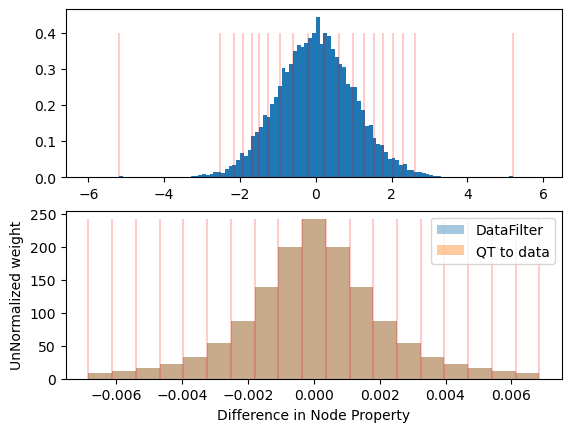

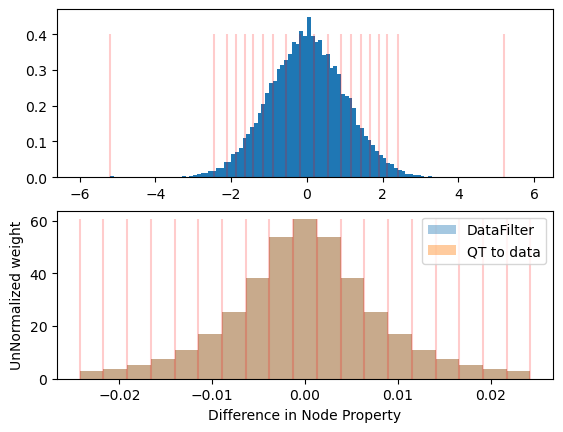

100%|████████████████████████████████████| 23294/23294 [00:53<00:00, 435.11it/s]




communityCnt 48


Network has been overwritten.
Network has been overwritten.


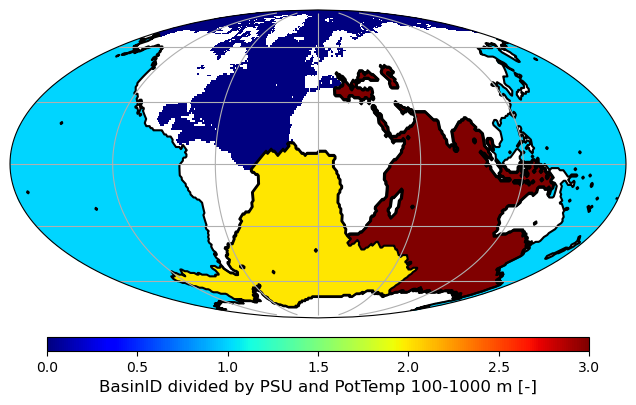

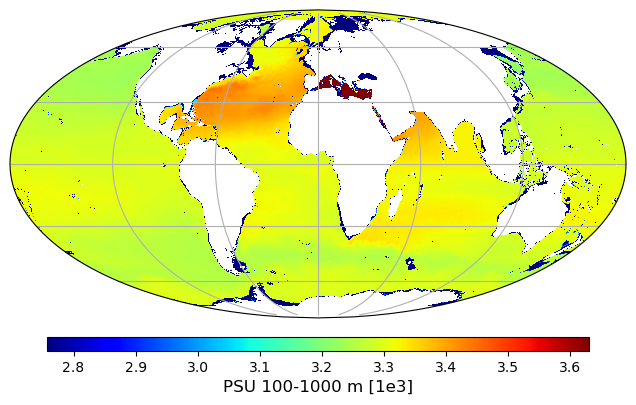

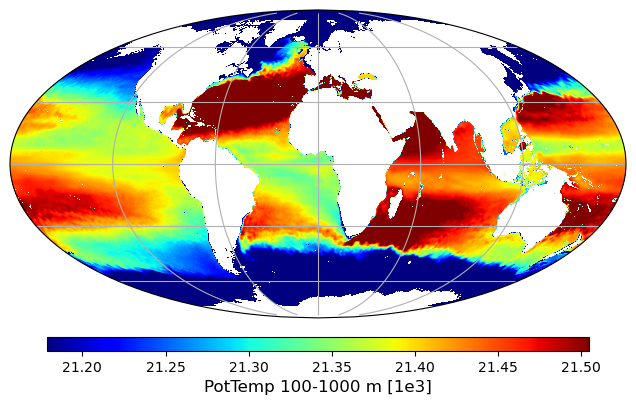

In [1]:
###################################
############# Imports #############
###################################
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset


#################################
### User define fields to use ###
#################################
useTemp = True;
useSalinity = True;

# Number of basins to detect (This is used
# by the Girvan-Newman algorithm).
minBasinCnt = [20, 20, 20]
minBasinCnt = [3, 3, 1]

#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
communityDetectionMethod = "Louvain-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
#mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
resolution = 1; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
detectionMethod = {"method":communityDetectionMethod,
                   "resolution":resolution,
                   "minBasinCnt":minBasinCnt,
                   "minBasinLargerThanSmallMergers":False,
                   "mergerPackage":mergerPackage}

# Set the edge weight scheme for node connections
# Options:
#    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
#    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
#    "useQTGaussianShiftedGaussianWeightDistribution"
edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                   "shortenFactor": 3,
                   "shiftFactor": 1,
                   "minWeight": 0.01}


# Define all depth ranges to calculate community division for
depthRanges = np.array([[0,100],[100,1000],[1000,6000]]);

scalarValue1 = "so_average"
unit1 = "PSU"
scalarValue2 = "thetao_average"
unit2 = "PotTemp"

# Short readme text to write to folder with images
if useTemp & useSalinity:
    usedFieldsStr = "{}/{}".format(unit1,unit2);
elif useSalinity:
    usedFieldsStr = "{}".format(unit1);
elif useTemp:
    usedFieldsStr = "{}".format(unit2);

# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/GLORYS12V1
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/GLORYS12V1/GLORYS12V1_1994_{}'.format(usedFieldsStr.replace("/", "_")))
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the {} values are shown with a colorbar that represents 1 std that are area weighted.".format(usedFieldsStr);
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the {} values are shown with a colorbar that represents 1 std that are area weighted.".format(usedFieldsStr);
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)
    

##################################################################
### Create basin objects and set Field for Community detection ###
##################################################################
for i in range(depthRanges.shape[0]):
    if i == 1:
        # Define ith depth range to evaluate
        depthRange = depthRanges[i,:];

        # Initial basin definition class
        body = ["Earth", "Mars", "Venus", "Moon"]
        body = body[0]
        basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                                 filename="{}_resampled_1deg.nc".format(body),
                                 body=body);

        # Define the equal area node options s.t. salinity is used for edge connections
        basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                        dataGrid =  os.getcwd()+"/GLORYS12V1/{0}_{1}_{2}m.nc".format(scalarValue1, depthRange[0], depthRange[1]),
                        parameter = "z",
                        parameterUnit = unit1,
                        parameterName = scalarValue1)
        basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                        dataGrid =  os.getcwd()+"/GLORYS12V1/{0}_{1}_{2}m.nc".format(scalarValue2, depthRange[0], depthRange[1]),
                        parameter = "z",
                        parameterUnit = unit2,
                        parameterName = scalarValue2)

        # Assign fields to use in community detection
        if useTemp & useSalinity:
            basins.useFields(fieldList=np.array(["Field2","Field3"]));
        elif useSalinity:
            basins.useFields(fieldList=np.array(["Field2"]));
        elif useTemp:
            basins.useFields(fieldList=np.array(["Field3"]));

        # Show all fields stored in basins object
        basins.getFields(usedFields = False)

        # Show all fields stored in basins object that will be used
        # for community detection.
        basins.getFields(usedFields = True)

        # Set minimum basin count
        detectionMethod['minBasinCnt'] = minBasinCnt[i]

        # Define basins based on user input boundaries.
        # For the Louvain-Girvan-Newman composite algorithm the variable
        # minBasinCnt refers to the number of basins to maintain that are
        # not completely isolated after running the louvain algorithm.
        basins.defineBasins(detectionMethod = detectionMethod,
                            edgeWeightMethod = edgeWeightMethod,
                            reducedRes={"on":True,"factor":1},
                            read=False,
                            write=True,
                            verbose=False)

        # Merge communities based off criteria 
        basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

        # Convert basinID equal area grid to regular grid
        basins.interp2regularGrid(mask=True)

        #####################################
        ### Plot results of community IDs ###
        #####################################
        EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                            outputDir = os.getcwd()+"/"+fldName,
                            fidName = "plotGlobal_{0}_{1}m.png".format(depthRange[0], depthRange[1]),
                            cmapOpts={"cmap":"jet",
                                      "cbar-title":"cbar-title",
                                      "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                            pltOpts={"valueType": "BasinID divided by {2} and {3} {0}-{1} m".format(depthRange[0], depthRange[1], unit1, unit2),
                                     "valueUnits": "-",
                                     "plotTitle":"",
                                     "plotZeroContour":False,
                                     "plotIntegerContours":True,
                                     "transparent":True},
                            savePNG=True,
                            saveSVG=False)

        #####################
        ### Plot Salinity ###
        #####################
        if useSalinity:
            # Write temp.nc that only has lat/lon/value
            #basins.simplifyNetCDF(inputPath=basins.EAinputs['dataGrid'],
            #                    outputPath='tempSimp.nc',
            #                    parameter=basins.EAinputs['parameter'])
            # Read netCDF4
            nc = Dataset('tempSimp_{}.nc'.format(scalarValue1))
            XX, YY = np.meshgrid(nc['lon'][:].data, nc['lat'][:].data)

            # Calculate area weighted average and standard deviation (for plotting)
            areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=np.diff(nc['lon'][:].data)[0],
                                                                                                      LonStEd = [-180,180],
                                                                                                      LatStEd = [-80-np.diff(nc['lon'][:].data)[0],90])
            ave, std = EC.utils.weightedAvgAndStd(nc['z'][:].data, areaWeights)

            # Plot PSU at depth interval
            EC.utils.plotGlobal(YY, XX, nc['z'][:].data,
                                outputDir = os.getcwd()+"/"+fldName,
                                fidName = "plotGlobal_{0}_{1}m_{2}.png".format(depthRange[0], depthRange[1], unit1),
                                cmapOpts={"cmap":"jet",
                                          "cbar-title":"cbar-title",
                                          "cbar-range":[ave-1*std,
                                                        ave+1*std]},
                                pltOpts={"valueType": "{2} {0}-{1} m".format(depthRange[0], depthRange[1], unit1),
                                         "valueUnits": "1e3",
                                         "plotTitle":"",
                                         "plotZeroContour":False,
                                         "transparent":True},
                                savePNG=True,
                                saveSVG=False)
            nc.close()

        ##################################
        ### Plot Potential Temperature ###
        ##################################
        if useTemp:
            # Write temp.nc that only has lat/lon/value
            #basins.simplifyNetCDF(inputPath=basins.EAinputs['dataGrid'],
            #                    outputPath='tempSimp.nc',
            #                    parameter=basins.EAinputs['parameter'])
            # Read netCDF4
            nc = Dataset('tempSimp_{}.nc'.format(scalarValue2))
            XX, YY = np.meshgrid(nc['lon'][:].data, nc['lat'][:].data)

            # Calculate area weighted average and standard deviation (for plotting)
            areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=np.diff(nc['lon'][:].data)[0],
                                                                                                      LonStEd = [-180,180],
                                                                                                      LatStEd = [-80-np.diff(nc['lon'][:].data)[0],90])
            ave, std = EC.utils.weightedAvgAndStd(nc['z'][:].data, areaWeights)

            # Plot PSU at depth interval
            EC.utils.plotGlobal(YY, XX, nc['z'][:].data,
                                outputDir = os.getcwd()+"/"+fldName,
                                fidName = "plotGlobal_{0}_{1}m_{2}.png".format(depthRange[0], depthRange[1], unit2),
                                cmapOpts={"cmap":"jet",
                                          "cbar-title":"cbar-title",
                                          "cbar-range":[ave-1*std,
                                                        ave+1*std]},
                                pltOpts={"valueType": "{2} {0}-{1} m".format(depthRange[0], depthRange[1], unit2),
                                         "valueUnits": "1e3",
                                         "plotTitle":"",
                                         "plotZeroContour":False,
                                         "transparent":True},
                                savePNG=True,
                                saveSVG=False)
            nc.close()




# Figure 5: (Bathymetry Basin Detection 0 and 60 Myr)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
from xml.etree import ElementTree as ET

def plotGlobal_raster_layers(lat, lon, values,
               outputDir=os.getcwd(),
               fidName="plotGlobal.svg",
               cmapOpts={"cmap": "tab10", "cbar-title": "cbar-title"},
               pltOpts={"valueType": "Class",
                        "valueUnits": "",
                        "plotTitle": "",
                        "plotZeroContour": False,
                        "plotIntegerContours": False,
                        "transparent": True},
               savePNG=False,
               saveSVG=True,
               mergeSVG=True,
               deleteLayers=True,
               showColorbar=True):
    """
    Rasterized class-layer plotting with overlaid SVG layers and colorbar placed below the map.
    """
    os.makedirs(outputDir, exist_ok=True)

    # Class info
    unique_vals = np.unique(values[~np.isnan(values)])
    num_classes = len(unique_vals)
    base_cmap = plt.get_cmap(cmapOpts.get("cmap", "tab20"), num_classes)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    layer_paths = []

    # Setup colorbar elements for merging
    cmap = ListedColormap([base_cmap(i / (num_classes - 1)) for i in range(num_classes)])
    norm = BoundaryNorm(boundaries=np.append(unique_vals, unique_vals[-1] + 1), ncolors=num_classes)

    # Final composite figure (map + colorbar)
    fig = plt.figure(figsize=(10, 5.5))
    gs = GridSpec(10, 1, figure=fig)
    ax_map = fig.add_subplot(gs[0:9, 0], projection=ccrs.Mollweide())
    ax_map.set_global()
    ax_map.axis("off")

    # Plot each class as rasterized imshow
    for i, val in enumerate(unique_vals):
        mask = np.where(values == val, val, np.nan)
        color = base_cmap(i / (num_classes - 1)) if num_classes > 1 else base_cmap(0)
        single_cmap = ListedColormap([color])

        ax_map.imshow(mask, origin="upper", extent=extent,
                      transform=ccrs.PlateCarree(),
                      cmap=single_cmap, vmin=val, vmax=val + 1,
                      interpolation="none", rasterized=True)

    if pltOpts.get("plotIntegerContours", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            levels = np.arange(len(unique_vals)) + 0.5
            ax_map.contour(lon, lat, values_cp, levels=levels, colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    if pltOpts.get("plotZeroContour", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            ax_map.contour(lon, lat, values_cp, levels=[0], colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    # Title
    ax_map.set_title(pltOpts.get("plotTitle", ""))
    ax_map.gridlines(draw_labels=False)

    # Horizontal colorbar below map
    if showColorbar:
        ax_cb = fig.add_subplot(gs[9, 0])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = plt.colorbar(sm, cax=ax_cb, orientation='horizontal',
                          ticks=unique_vals + 0.5)
        cb.ax.set_xticklabels( unique_vals.astype(int) )
        cb.set_label(label="{} [{}]".format(pltOpts['valueType'], pltOpts['valueUnits']), size=10)
        cb.ax.tick_params(labelsize=8)

    # Save final composite
    out_svg = os.path.join(outputDir, fidName)
    out_png = out_svg.replace(".svg", ".png")

    if saveSVG:
        plt.savefig(out_svg, format="svg", dpi=600, transparent=pltOpts.get("transparent", False))
    if savePNG:
        plt.savefig(out_png, format="png", dpi=600, transparent=pltOpts.get("transparent", False))

    plt.close()


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_ReconBathy_16
agei 0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry

Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_0Ma.nc
	parameter: z
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_0Ma.nc
	parameter: z
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:8755: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


sh: 1: temp.txt: not found
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
100%|███████████████████████████████████| 24534/24534 [00:05<00:00, 4310.43it/s]


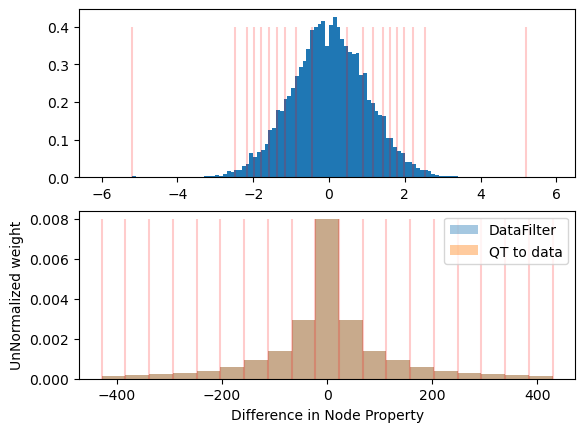

100%|████████████████████████████████████| 24534/24534 [00:31<00:00, 790.00it/s]


Louvain Communities (323), Target (88), Isolated Communities 78
Time: -0.0001659393310546875 seconds
Time: -1.1920928955078125e-06 seconds
Time: -11.381062030792236 seconds
Time: -1.8835067749023438e-05 seconds
Time: -0.0006146430969238281 seconds
Network has been overwritten.


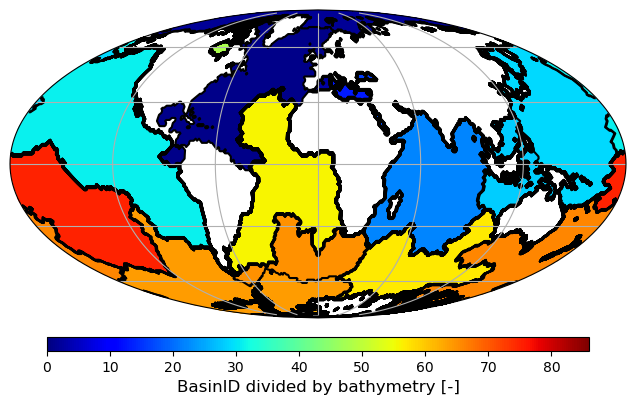

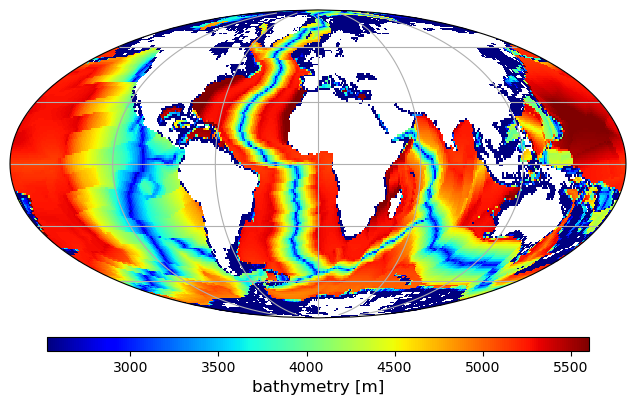

In [2]:
#################################################
#################### Imports ####################
#################################################
from netCDF4 import Dataset
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import copy as cp


###################################
## Define Functions for Figure 5 ##
###################################
def load_netcdf_data(age):
    # Read bathymetry file.
    ds = Dataset(os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age))

    # Assign data to variables
    lon, lat = np.meshgrid(ds['lon'][:], ds['lat'][:]);
    z = ds['z'][:].data;
    continents = ds['z'][:].mask;
    continentsnew = cp.deepcopy(continents).astype(float)
    continentsnew[continentsnew==0] = np.nan

    
    # Close dataset
    ds.close();
    
    # Return variables
    return lon, lat, z, continentsnew


#########################################
### Define Community Detection Inputs ###
#########################################
# plot Options
saveSVG = False;

# Reconstruction periods
ages = [0, 60];
ages = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80];
ages = [0]
agestr = [ str(age) for age in ages ];
minBasinCntV = [3, 5];
minBasinCntV = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
minBasinCntV = [10]
minBasinCntVstr = [ str(cnt) for cnt in minBasinCntV ];

# Simple test
#communityDetectionMethod = "Louvain"
communityDetectionMethod = "Louvain-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
resolution = 5; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
detectionMethod = {"method":communityDetectionMethod,
                   "resolution":resolution,
                   "minBasinCnt":3,
                   "minBasinLargerThanSmallMergers":False,
                   "mergerPackage":mergerPackage}

# Set the edge weight scheme for node connections
# Options:
#    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
#    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
#    "useQTGaussianShiftedGaussianWeightDistribution"
edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                   "shortenFactor": 3,
                   "shiftFactor": 1,
                   "minWeight": 0.01}
# edgeWeightMethod = {"method":"useLogistic"}



# Make folder to hold figure results
!mkdir -p figures/CommunityDetectionMethodsPaper/
fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_ReconBathy')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
    readmetxt = "Note that the Bathymetry values ({0} Ma) are shown with a colorbar that represents 1 std that are area weighted.".format(", ".join(agestr));
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: [{}]".format(", ".join(minBasinCntVstr));
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
elif edgeWeightMethod['method'] == "useLogistic":
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
    readmetxt = "\nUsing S/distanceV edge weight";
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    readmetxt += "\n";
    readmetxt += "\nTesting: Results should not be used for publication";
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

    
#################################################################
### Create basin object and set Field for Community detection ###
#################################################################
for i in range(len(minBasinCntV)):
    # Set reconstruction parameters
    detectionMethod['minBasinCnt'] = minBasinCntV[i]
    agei = ages[i]
    
    print("agei",agei)
    


    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);

    # Add bathymetry field
    basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                    dataGrid =  os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(agei),
                    parameter = "z",
                    parameterUnit = basins.Fields["Field1"]["parameterUnit"],
                    parameterName = basins.Fields["Field1"]["parameterName"])
    # basins.addField(resolution = basins.Fields["Field1"]["resolution"],
    #                 dataGrid =  os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age[1]),
    #                 parameter = "z",
    #                 parameterUnit = basins.Fields["Field1"]["parameterUnit"],
    #                 parameterName = basins.Fields["Field1"]["parameterName"])

    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field2"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)
    
    # Set field mask parameters
    fieldMaskParameter = {"usedField":0, "fliprl":False, "flipud":True}
    #basins.setFieldMask(usedField = 0, fliprl=False, flipud=True)
    
    #continue


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        fieldMaskParameter = fieldMaskParameter,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)
    
    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)

    
    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, cp.deepcopy(basins.BasinIDA),
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(agei),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=saveSVG)
    
    
    plotGlobal_raster_layers(
        lat=basins.lat,
        lon=basins.lon,
        values=cp.deepcopy(basins.BasinIDA),
        outputDir=os.path.join(os.getcwd(), fldName),
        fidName="plotGlobal_{0}_layered.svg".format(agei),
        cmapOpts={
            "cmap": "jet",
            "cbar-title": "Basin ID"
        },
        pltOpts={
            "valueType": "BasinID / {}".format(basins.Fields["Field1"]["parameterName"]),
            "valueUnits": "-",
            "plotTitle": "Basin Classification at {} Ma".format(agei),
            "plotZeroContour": False,
            "plotIntegerContours": True,
            "transparent": True
        },
        savePNG=False,
        saveSVG=True,
        mergeSVG=False,  # no merging needed since everything is now in one figure
        deleteLayers=True,
        showColorbar=True
    )


    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}_{1}.png".format(basins.Fields["Field1"]['parameterName'], agei),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=saveSVG)


In [ ]:
# Resolution 1:
# Louvain Communities (179), Target (87), Isolated Communities 77
# Time: -0.00014662742614746094 seconds
# Time: -1.1920928955078125e-06 seconds
# Time: -1.1545684337615967 seconds
# Network has been overwritten.

# Resolution 5:
# Louvain Communities (323), Target (88), Isolated Communities 78
# Time: -0.0001475811004638672 seconds
# Time: -1.1920928955078125e-06 seconds
# Time: -11.591257333755493 seconds
# Network has been overwritten.


# Resolution 1:
# Louvain Communities (179), Target (87), Isolated Communities 77
# Time: -0.00013637542724609375 seconds
# Time: -9.5367431640625e-07 seconds
# Time: -1.0935876369476318 seconds
# Time: -1.52587890625e-05 seconds
# Time: -0.0004665851593017578 seconds



# Resolution 5:
# Louvain Communities (323), Target (88), Isolated Communities 78
# Time: -0.0001659393310546875 seconds
# Time: -1.1920928955078125e-06 seconds
# Time: -11.381062030792236 seconds
# Time: -1.8835067749023438e-05 seconds
# Time: -0.0006146430969238281 seconds



In [4]:
(323/179)*3

(323/179)*2 *(2*323/179)



13.024437439530603

## FIXING: svg contours issue

In [11]:
import cartopy.crs as ccrs # type: ignore
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

def plotGlobal(lat, lon, values,
               outputDir = os.getcwd(),
               fidName = "plotGlobal.png",
               cmapOpts={"cmap":"viridis",
                         "cbar-title":"cbar-title",
                         "cbar-range":[0,1]},
               pltOpts={"valueType": "Bathymetry",
                        "valueUnits": "m",
                        "plotTitle":"",
                        "plotZeroContour":False,
                        "plotIntegerContours":False,
                        "transparent":False},
               saveSVG=False,
               savePNG=False):
    """
    plotGlobal function is used to plot global ranging datasets that
    are represented with evenly spaced latitude and longitude values.

    Parameters
    ----------
    lat : NUMPY ARRAY
        nx2n array representing cell registered latitudes, in deg,
        ranging from [-90, 90]. Latitudes change from row to row.
    lon : NUMPY ARRAY
        nx2n array representing cell registered longitudes, in deg,
        ranging from [-180, 180]. Longitudes change from column to column.
    Values : NUMPY ARRAY
        nx2n array representing cell registered geographic data, in [-] units.
    cmapOpts : DICTIONARY
        A set of options to format the color map and bar for the plot
    pltOpts : DICTIONARY
        A set of options to format the plot
    saveSVG : BOOLEAN
        An option to save an SVG output. The default is False.
    savePNG : BOOLEAN
        An option to save an PNG output. The default is False.

    Returns
    -------
    None.
    """
    # Start making figure
    ## Create a figure
    fig = plt.figure(figsize=(10, 5))

    ## Set up the Mollweide projection
    ax = plt.axes(projection=ccrs.Mollweide())

    ## Add the plot using pcolormesh
    mesh = ax.pcolormesh(lon, lat, values, transform=ccrs.PlateCarree(), cmap=cmapOpts["cmap"],
                         vmin=cmapOpts['cbar-range'][0], vmax=cmapOpts['cbar-range'][1],
                         rasterized=True)

    ## Add zero contour value
    try:
        if pltOpts["plotZeroContour"]:
            # Set any np.nan values to 0.ccrs
            values[np.isnan(values)] = 0;
            zeroContour = ax.contour(lon, lat, values, levels=[0], colors='black', transform=ccrs.PlateCarree())
    except:
        # Case where pltOpts["plotZeroContour"] was not defined
        pass

    ## Add contours in integer steps (useful for dividing catagorical data)
    try:
        if pltOpts["plotIntegerContours"]:
            # Set any np.nan values to 0.
            values[np.isnan(values)] = 0;
            zeroContour = ax.contour(lon, lat, values, levels=np.arange(len(np.unique(values)))+1/2, colors='black', transform=ccrs.PlateCarree())
    except:
        # Case where pltOpts["plotIntegerContours"] was not defined
        pass

    ## Add a colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, aspect=40, shrink=0.7)
    cbar.set_label(label="{} [{}]".format(pltOpts['valueType'], pltOpts['valueUnits']), size=12);
    cbar.ax.tick_params(labelsize=10)  # Adjust the size of colorbar ticks

    ## Add gridlines
    ax.gridlines()

    ## Set a title
    plt.title(pltOpts['plotTitle'])

    ## Set transparency value
    try:
        pltOpts["transparent"];
    except:
        pltOpts["transparent"] = False;

    # Save figure
    if savePNG:
        plt.savefig("{}/{}".format(outputDir,fidName), dpi=600, transparent=pltOpts["transparent"])
    if saveSVG:
        plt.savefig("{}/{}".format(outputDir,fidName.replace(".png", ".svg")), dpi=600)





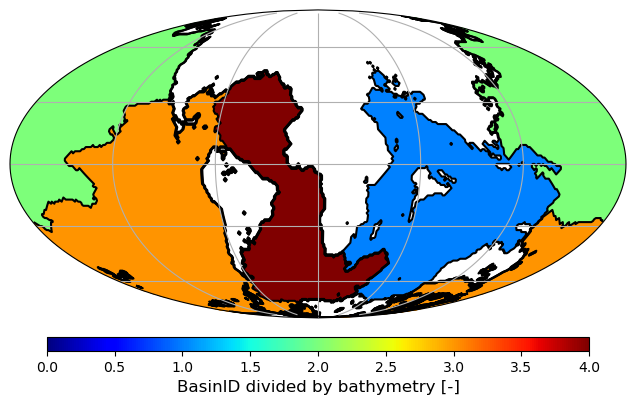

In [12]:
#####################################
### Plot results of community IDs ###
#####################################
basins.BasinIDA[basins.BasinIDA==0] = np.nan;
plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal_{0}.png".format(agei),
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                    pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "plotIntegerContours":True,
                             "transparent":True},
                    savePNG=False,
                    saveSVG=saveSVG)


In [24]:
import cartopy.crs as ccrs # type: ignore
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import os

def plotGlobal(lat, lon, values,
               outputDir = os.getcwd(),
               fidName = "plotGlobal.png",
               cmapOpts={"cmap":"viridis",
                         "cbar-title":"cbar-title",
                         "cbar-range":[0,1]},
               pltOpts={"valueType": "Bathymetry",
                        "valueUnits": "m",
                        "plotTitle":"",
                        "plotZeroContour":False,
                        "plotIntegerContours":False,
                        "transparent":False},
               saveSVG=False,
               savePNG=False):
    """
    plotGlobal function is used to plot global ranging datasets that
    are represented with evenly spaced latitude and longitude values.

    Parameters
    ----------
    lat : NUMPY ARRAY
        nx2n array representing cell registered latitudes, in deg,
        ranging from [-90, 90]. Latitudes change from row to row.
    lon : NUMPY ARRAY
        nx2n array representing cell registered longitudes, in deg,
        ranging from [-180, 180]. Longitudes change from column to column.
    Values : NUMPY ARRAY
        nx2n array representing cell registered geographic data, in [-] units.
    cmapOpts : DICTIONARY
        A set of options to format the color map and bar for the plot
    pltOpts : DICTIONARY
        A set of options to format the plot
    saveSVG : BOOLEAN
        An option to save an SVG output. The default is False.
    savePNG : BOOLEAN
        An option to save an PNG output. The default is False.

    Returns
    -------
    None.
    """
    # Start making figure
    ## Create a figure
    fig = plt.figure(figsize=(10, 5))

    ## Set up the Mollweide projection
    ax = plt.axes(projection=ccrs.Mollweide())

    ## Add the plot using pcolormesh
    # Extract unique values (assumed to be integers or discrete classes)
    unique_vals = np.unique(values[~np.isnan(values)])
    num_classes = len(unique_vals)

    # Base colormap for class colors
    if isinstance(cmapOpts["cmap"], str):
        base_cmap = plt.get_cmap(cmapOpts["cmap"], num_classes)
    else:
        base_cmap = cmapOpts["cmap"]
        
    discrete_cmap = ListedColormap(base_cmap(np.linspace(0, 1, num_classes)))
    norm = BoundaryNorm(boundaries=np.append(unique_vals, unique_vals[-1] + 1), ncolors=num_classes)


    # Loop through each class and draw a separate raster image
    for i, val in enumerate(unique_vals):
        # Mask values: retain only the current class
        masked_vals = np.where(values == val, val, np.nan)

        # Define a single-color colormap for this class only
        single_color = base_cmap(i / (num_classes - 1)) if num_classes > 1 else base_cmap(0)
        single_cmap = ListedColormap([single_color])

        # Plot this class as a separate raster layer
        ax.pcolormesh(
            lon, lat, masked_vals,
            transform=ccrs.PlateCarree(),
            cmap=single_cmap,
            vmin=val, vmax=val + 1,
            rasterized=True  # <- critical to make it a separate image
        )
    
    
    ## Add zero contour value
    try:
        if pltOpts["plotZeroContour"]:
            # Set any np.nan values to 0.ccrs
            values[np.isnan(values)] = 0;
            zeroContour = ax.contour(lon, lat, values, levels=[0], colors='black', transform=ccrs.PlateCarree())
    except:
        # Case where pltOpts["plotZeroContour"] was not defined
        pass

    ## Add contours in integer steps (useful for dividing catagorical data)
    try:
        if pltOpts["plotIntegerContours"]:
            # Set any np.nan values to 0.
            values[np.isnan(values)] = 0;
            zeroContour = ax.contour(lon, lat, values, levels=np.arange(len(np.unique(values)))+1/2, colors='black', transform=ccrs.PlateCarree())
    except:
        # Case where pltOpts["plotIntegerContours"] was not defined
        pass

    # Add discrete colorbar
    # Assume unique_vals, discrete_cmap, and norm have been defined
    sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
    sm.set_array([])  # For older Matplotlib versions

    # Tick positions shifted by 0.5
    tick_locs = unique_vals + 0.5
    tick_labels = unique_vals.astype(int)  # or any custom labels

    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40, shrink=0.7,
                        ticks=tick_locs)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label(label="{} [{}]".format(pltOpts['valueType'], pltOpts['valueUnits']), size=12)
    cbar.ax.tick_params(labelsize=10)

    ## Add gridlines
    ax.gridlines()

    ## Set a title
    plt.title(pltOpts['plotTitle'])

    ## Set transparency value
    try:
        pltOpts["transparent"];
    except:
        pltOpts["transparent"] = False;

    # Save figure
    if savePNG:
        plt.savefig("{}/{}".format(outputDir,fidName), dpi=600, transparent=pltOpts["transparent"])
    if saveSVG:
        plt.savefig("{}/{}".format(outputDir,fidName.replace(".png", ".svg")), dpi=600)





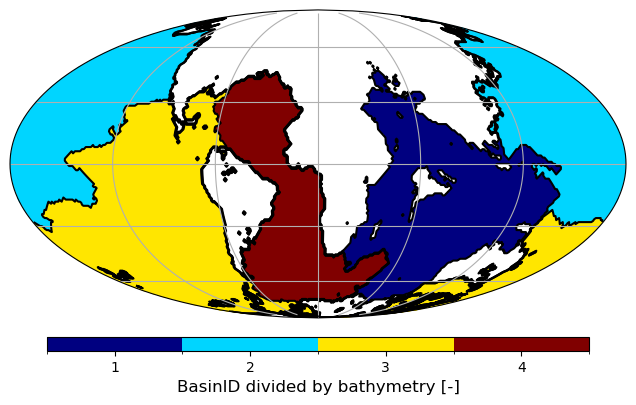

In [25]:
#####################################
### Plot results of community IDs ###
#####################################
basins.BasinIDA[basins.BasinIDA==0] = np.nan;
plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                    outputDir = os.getcwd()+"/"+fldName,
                    fidName = "plotGlobal_{0}_test.png".format(agei),
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                    pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False,
                             "plotIntegerContours":True,
                             "transparent":True},
                    savePNG=False,
                    saveSVG=saveSVG)


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
from xml.etree import ElementTree as ET

def plotGlobal_raster_layers(lat, lon, values,
               outputDir=os.getcwd(),
               fidName="plotGlobal.svg",
               cmapOpts={"cmap": "tab10", "cbar-title": "cbar-title"},
               pltOpts={"valueType": "Class",
                        "valueUnits": "",
                        "plotTitle": "",
                        "plotZeroContour": False,
                        "plotIntegerContours": False,
                        "transparent": True},
               savePNG=False,
               saveSVG=True,
               mergeSVG=True,
               deleteLayers=True,
               showColorbar=True):
    """
    Rasterized class-layer plotting with overlaid SVG layers and colorbar placed below the map.
    """
    os.makedirs(outputDir, exist_ok=True)

    # Class info
    unique_vals = np.unique(values[~np.isnan(values)])
    num_classes = len(unique_vals)
    base_cmap = plt.get_cmap(cmapOpts.get("cmap", "tab10"), num_classes)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    layer_paths = []

    # Setup colorbar elements for merging
    cmap = ListedColormap([base_cmap(i / (num_classes - 1)) for i in range(num_classes)])
    norm = BoundaryNorm(boundaries=np.append(unique_vals, unique_vals[-1] + 1), ncolors=num_classes)

    # Final composite figure (map + colorbar)
    fig = plt.figure(figsize=(10, 5.5))
    gs = GridSpec(10, 1, figure=fig)
    ax_map = fig.add_subplot(gs[0:9, 0], projection=ccrs.Mollweide())
    ax_map.set_global()
    ax_map.axis("off")

    # Plot each class as rasterized imshow
    for i, val in enumerate(unique_vals):
        mask = np.where(values == val, val, np.nan)
        color = base_cmap(i / (num_classes - 1)) if num_classes > 1 else base_cmap(0)
        single_cmap = ListedColormap([color])

        ax_map.imshow(mask, origin="upper", extent=extent,
                      transform=ccrs.PlateCarree(),
                      cmap=single_cmap, vmin=val, vmax=val + 1,
                      interpolation="none", rasterized=True)

    if pltOpts.get("plotIntegerContours", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            levels = np.arange(len(unique_vals)) + 0.5
            ax_map.contour(lon, lat, values_cp, levels=levels, colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    if pltOpts.get("plotZeroContour", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            ax_map.contour(lon, lat, values_cp, levels=[0], colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    # Title
    ax_map.set_title(pltOpts.get("plotTitle", ""))
    ax_map.gridlines(draw_labels=False)

    # Horizontal colorbar below map
    if showColorbar:
        ax_cb = fig.add_subplot(gs[9, 0])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = plt.colorbar(sm, cax=ax_cb, orientation='horizontal',
                          ticks=unique_vals + 0.5)
        cb.ax.set_xticklabels( int(unique_vals) )
        cb.set_label(label="{} [{}]".format(pltOpts['valueType'], pltOpts['valueUnits']), size=10)
        cb.ax.tick_params(labelsize=8)

    # Save final composite
    out_svg = os.path.join(outputDir, fidName)
    out_png = out_svg.replace(".svg", ".png")

    if saveSVG:
        plt.savefig(out_svg, format="svg", dpi=600, transparent=pltOpts.get("transparent", False))
    if savePNG:
        plt.savefig(out_png, format="png", dpi=600, transparent=pltOpts.get("transparent", False))

    plt.close()


In [34]:
plotGlobal_raster_layers(
    lat=basins.lat,
    lon=basins.lon,
    values=basins.BasinIDA,
    outputDir=os.path.join(os.getcwd(), fldName),
    fidName="plotGlobal_{0}_test.svg".format(agei),
    cmapOpts={
        "cmap": "jet",
        "cbar-title": "Basin ID"
    },
    pltOpts={
        "valueType": "BasinID / {}".format(basins.Fields["Field1"]["parameterName"]),
        "valueUnits": "-",
        "plotTitle": "Basin Classification at {} Ma".format(agei),
        "plotZeroContour": False,
        "plotIntegerContours": True,
        "transparent": True
    },
    savePNG=False,
    saveSVG=True,
    mergeSVG=False,  # no merging needed since everything is now in one figure
    deleteLayers=True,
    showColorbar=True
)


# Figure X: (Community detection with Leiden ensemble consensus method) 


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.05 50 10
0.01 50 10
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_Etopo_ResolutionTest_119

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|███████████████████████████████████| 24441/24441 [00:05<00:00, 4462.92it/s]


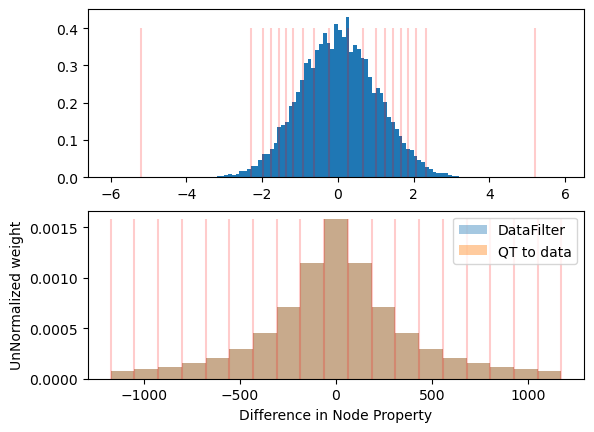

100%|████████████████████████████████████| 24441/24441 [00:30<00:00, 794.81it/s]


len(LDcommunities) 162
Network has been overwritten.
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_Etopo_ResolutionTest_120

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|███████████████████████████████████| 24441/24441 [00:05<00:00, 4269.39it/s]


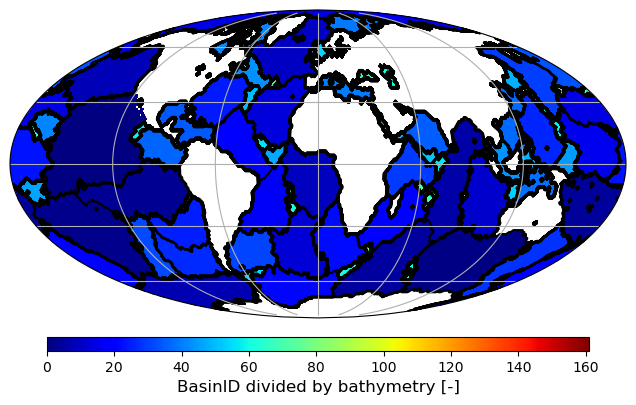

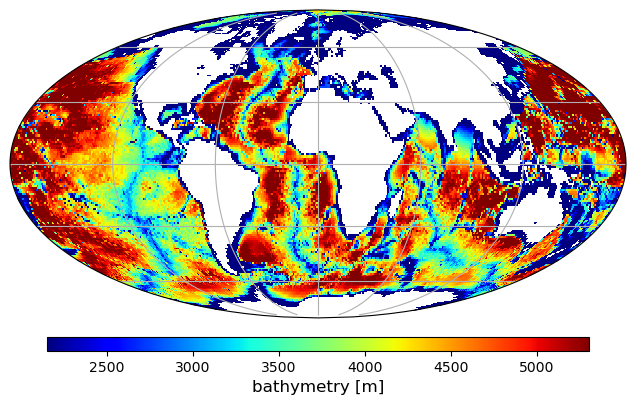

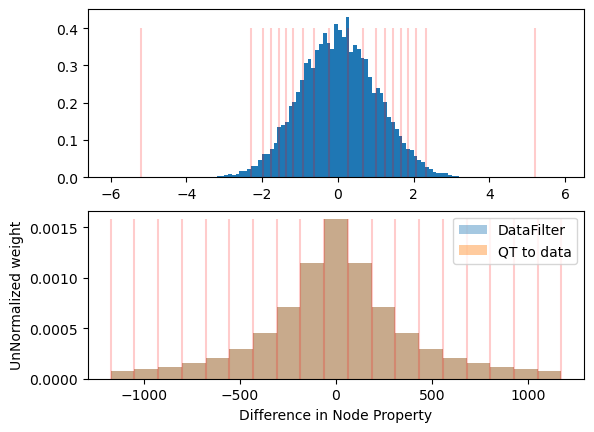

100%|████████████████████████████████████| 24441/24441 [00:31<00:00, 784.54it/s]


len(LDcommunities) 93
Network has been overwritten.


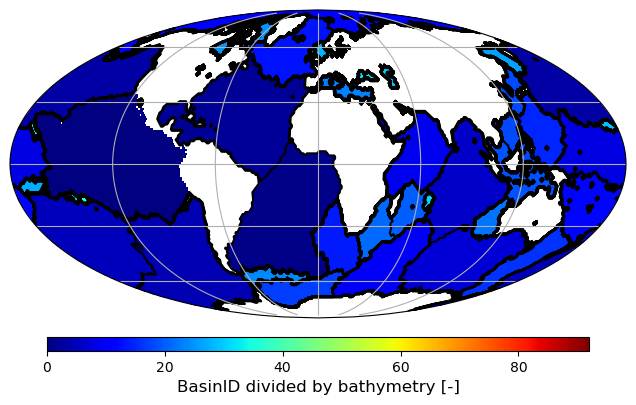

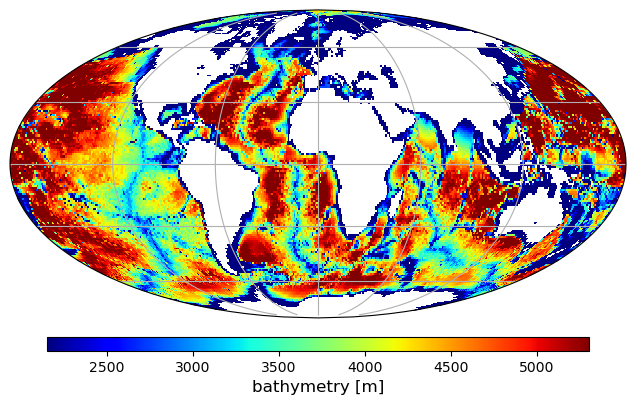

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
#communityDetectionMethod = "Louvain-Girvan-Newman"
communityDetectionMethod = "Leiden"
#communityDetectionMethod = "Leiden-Girvan-Newman"


# Define basin merging criteria
#mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Full test
#resolution = 10; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
#resolution = 5; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
#resolution = 1; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
#resolution = 0.5; # Allows for more basins s.t. the Girvan-Newman algorithm can merge them.
resolutions = [.05, .01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnt = 10
minBasinCnts = [10, 10]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50, 50];


# For Leiden-GN with RB modularity quality function
# Recovers reasonable present-day basin boundaries with Etopo
# resolutions = [1, .5];
# minBasinCnts = [-6, -4];
# ensembleSizes = [50, 50];

# For Leiden-GN, resolution 1, Lite
# with RBConfigurationVertexPartition and ensembleSize=50
# communityDetectionMethod = "Leiden-Girvan-Newman"
# minBasinCnt=-6
# mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
# resolutions = [1]

# communityDetectionMethod = "Leiden-Girvan-Newman"
# with RBConfigurationVertexPartition and ensembleSize=50
# minBasinCnt=-4
# mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
# resolutions = [.5]


for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)
# Run for multiple resolutions
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}
    # edgeWeightMethod = {"method":"useLogistic"}


    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_Etopo_ResolutionTest')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


# Same as above cell - except used for surface constraints (Salinity)

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 10
Storing images in figures/CommunityDetectionMethodsPaper/SalinityPotTemp_1

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry

Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/so_average_0_100m.nc
	parameter: z
	parameterUnit: PSU
	parameterName: so_average

Field3
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/thetao_average_0_100m.nc
	parameter: z
	parameterUnit: PotTemp
	parameterName: thetao_average


Used fields
---------------
Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/so_average_0_100m.nc
	parameter: z
	parameterUnit: PSU
	parameterName: so_average

Field3
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/GLORYS12V1/thetao_average_0_100m.nc
	parameter: z
	parameterUnit: PotTe

/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


sh: 1: temp.txt: not found
sh: 1: temp.txt: not found
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24746/24746 [00:07<00:00, 3415.17it/s]


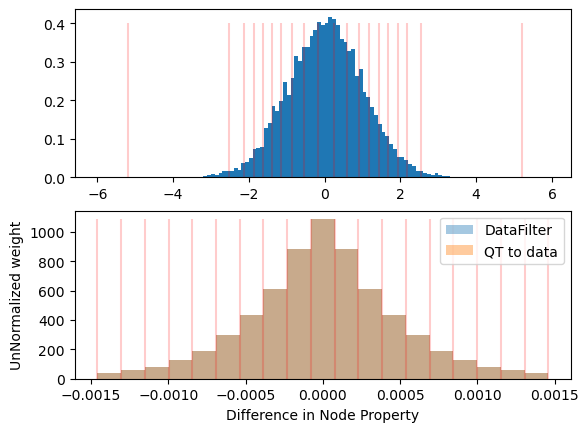

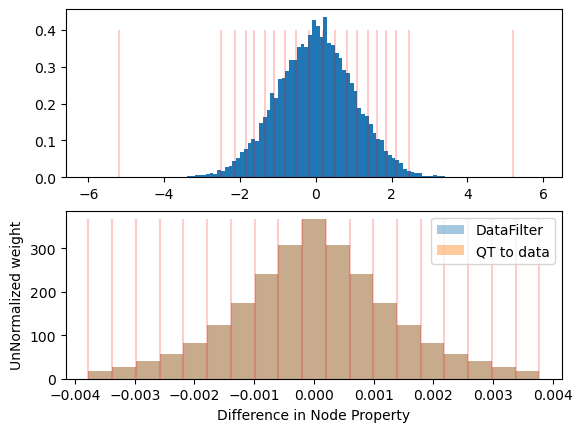

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24746/24746 [00:54<00:00, 455.58it/s]


len(LDcommunities) 56
Network has been overwritten.
Network has been overwritten.


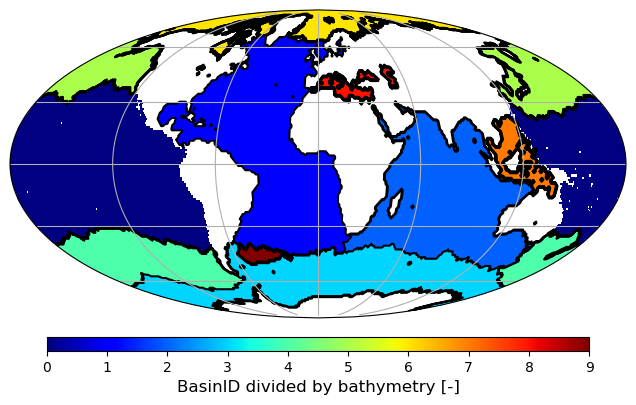

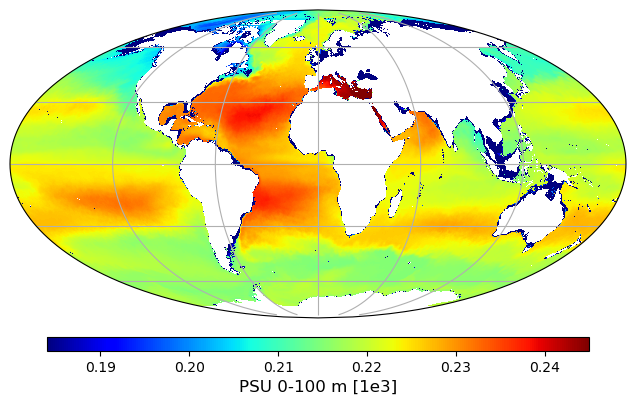

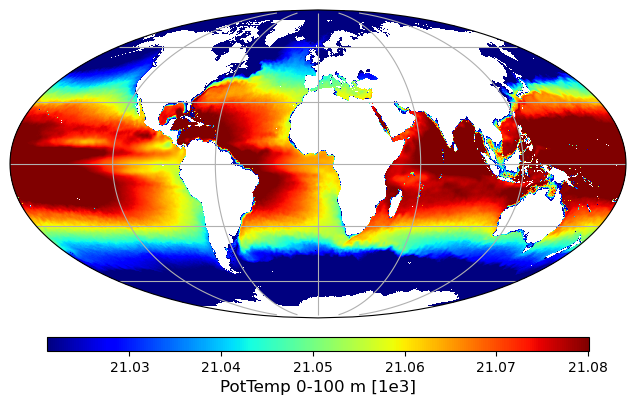

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
#communityDetectionMethod = "Louvain-Girvan-Newman"
communityDetectionMethod = "Leiden"
#communityDetectionMethod = "Leiden-Girvan-Newman"


# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
#mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [0.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [10]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Define fields to use for community detection
useSalinityOnly = False;
usePotTempOnly = False;

if useSalinityOnly:
    RunType= "Salinity"
elif usePotTempOnly:
    RunType= "PotTemp"
else:
    RunType= "SalinityPotTemp"

# Define values for loading fields
scalarValue1 = "so_average"
unit1 = "PSU"
scalarValue2 = "thetao_average"
unit2 = "PotTemp"

# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolutions
# Define all depth ranges to calculate community division for
depthRanges = np.array([[0,100]]);

# Iterate over different depth ranges to evaluate
for i in range(depthRanges.shape[0]):
    # Define ith depth range to evaluate
    depthRange = depthRanges[i,:];
    
    # Run for multiple resolution, ensembleSize, and minBasinCnt
    for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
        detectionMethod = {"method":communityDetectionMethod,
                           "resolution":resolution,
                           "minBasinCnt":minBasinCnt,
                           "ensembleSize":ensembleSize,
                           "minBasinLargerThanSmallMergers":False,
                           "mergerPackage":mergerPackage}

        # Set the edge weight scheme for node connections
        # Options:
        #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
        #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
        #    "useQTGaussianShiftedGaussianWeightDistribution"
        edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                           "shortenFactor": 3,
                           "shiftFactor": 1,
                           "minWeight": 0.01}
        # edgeWeightMethod = {"method":"useLogistic"}


        # Make folder to hold figure results
        !mkdir -p figures/CommunityDetectionMethodsPaper/
        fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/{}'.format(RunType))
        print("Storing images in {}".format(fldName))

        # Short readme text to write to folder with images
        if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
            readmetxt = "Note that the {}/{} values are shown with a colorbar that represents 1 std that are area weighted.".format(unit1,unit2);
            readmetxt += "useSalinityOnly is {}; usePotTempOnly is {}".format(useSalinityOnly, usePotTempOnly);
            readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
            readmetxt += "\nUsing S/distanceV edge weight";
            readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
            readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
            readmetxt += "\nThe CDF used for S is calculated as follows:";
            readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
            readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
            readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
            readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
            readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
            readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
            readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
            readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
            readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
            readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
            readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
            readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

            readmetxt += "\n";
            readmetxt += "\nTesting: Results should not be used for publication";
        elif edgeWeightMethod['method'] == "useLogistic":
            readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
            readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
            readmetxt = "\nUsing S/distanceV edge weight";
            readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
            readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
            readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
            readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

            readmetxt += "\n";
            readmetxt += "\nTesting: Results should not be used for publication";


        with open(fldName+"/readme.txt", "w") as text_file:
            text_file.write(readmetxt)


        #################################################################
        ### Create basin object and set Field for Community detection ###
        #################################################################

        # Create basin object
        body = ["Earth", "Mars", "Venus", "Moon"]
        body = body[0]
        basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                                 filename="{}_resampled_1deg.nc".format(body),
                                 body=body);
        
        # Define the equal area node options s.t. salinity is used for edge connections
        basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                        dataGrid =  os.getcwd()+"/GLORYS12V1/{0}_{1}_{2}m.nc".format(scalarValue1, depthRange[0], depthRange[1]),
                        parameter = "z",
                        parameterUnit = unit1,
                        parameterName = scalarValue1)
        basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                        dataGrid =  os.getcwd()+"/GLORYS12V1/{0}_{1}_{2}m.nc".format(scalarValue2, depthRange[0], depthRange[1]),
                        parameter = "z",
                        parameterUnit = unit2,
                        parameterName = scalarValue2)
        
        # Assign fields to use in community detection
        # Field1: Bathymetry
        # Field2: Salinity
        # Field3: Temperature
        if useSalinityOnly:
            basins.useFields(fieldList=np.array(["Field2"]))
        elif usePotTempOnly:
            basins.useFields(fieldList=np.array(["Field3"]))
        else:
            basins.useFields(fieldList=np.array(["Field2","Field3"]))

        # Show all fields stored in basins object
        basins.getFields(usedFields = False)

        # Show all fields stored in basins object that will be used
        # for community detection.
        basins.getFields(usedFields = True)
        
        #########################################
        ### Run Community Detection Algorithm ###
        #########################################

        # Define basins based on user input boundaries.
        # For the Louvain-Girvan-Newman composite algorithm the variable
        # minBasinCnt refers to the number of basins to maintain that are
        # not completely isolated after running the louvain algorithm.
        basins.defineBasins(detectionMethod = detectionMethod,
                            edgeWeightMethod = edgeWeightMethod,
                            reducedRes={"on":True,"factor":1},
                            read=False,
                            write=True,
                            verbose=False)


        # Merge communities based off criteria 
        basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

        # Convert basinID equal area grid to regular grid
        basins.interp2regularGrid(mask=True)


        #####################################
        ### Plot results of community IDs ###
        #####################################
        EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                            outputDir = os.getcwd()+"/"+fldName,
                            fidName = "plotGlobal.png",
                            cmapOpts={"cmap":"jet",
                                      "cbar-title":"cbar-title",
                                      "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                            pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                     "valueUnits": "-",
                                     "plotTitle":"",
                                     "plotZeroContour":False,
                                     "plotIntegerContours":True,
                                     "transparent":True},
                            savePNG=True,
                            saveSVG=False)

        # Calculate area weighted average and standard deviation (for plotting)
        # areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
        #                                                                                           LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
        #                                                                                           LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
        # ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

        #########################
        ### Plot input fields ###
        #########################
        if not usePotTempOnly:
            # Read netCDF4
            nc = Dataset('tempSimp_so_average.nc')
            XX, YY = np.meshgrid(nc['lon'][:].data, nc['lat'][:].data)

            # Calculate area weighted average and standard deviation (for plotting)
            areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=np.diff(nc['lon'][:].data)[0],
                                                                                                      LonStEd = [-180,180],
                                                                                                      LatStEd = [-80-np.diff(nc['lon'][:].data)[0],90])
            ave, std = EC.utils.weightedAvgAndStd(nc['z'][:].data, areaWeights)

            # Plot PSU at depth interval
            EC.utils.plotGlobal(YY, XX, nc['z'][:].data,
                                outputDir = os.getcwd()+"/"+fldName,
                                fidName = "plotGlobal_{0}_{1}m_{2}.png".format(depthRange[0], depthRange[1], basins.Fields["Field2"]["parameterUnit"]),
                                cmapOpts={"cmap":"jet",
                                          "cbar-title":"cbar-title",
                                          "cbar-range":[ave-1*std,
                                                        ave+1*std]},
                                pltOpts={"valueType": "{2} {0}-{1} m".format(depthRange[0], depthRange[1], basins.Fields["Field2"]["parameterUnit"]),
                                         "valueUnits": "1e3",
                                         "plotTitle":"",
                                         "plotZeroContour":False,
                                         "transparent":True},
                                savePNG=True,
                                saveSVG=False)
            nc.close()
            
        if not useSalinityOnly:
            # Read netCDF4
            nc = Dataset('tempSimp_thetao_average.nc')
            XX, YY = np.meshgrid(nc['lon'][:].data, nc['lat'][:].data)

            # Calculate area weighted average and standard deviation (for plotting)
            areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=np.diff(nc['lon'][:].data)[0],
                                                                                                      LonStEd = [-180,180],
                                                                                                      LatStEd = [-80-np.diff(nc['lon'][:].data)[0],90])
            ave, std = EC.utils.weightedAvgAndStd(nc['z'][:].data, areaWeights)

            # Plot PSU at depth interval
            EC.utils.plotGlobal(YY, XX, nc['z'][:].data,
                                outputDir = os.getcwd()+"/"+fldName,
                                fidName = "plotGlobal_{0}_{1}m_{2}.png".format(depthRange[0], depthRange[1], basins.Fields["Field3"]["parameterUnit"]),
                                cmapOpts={"cmap":"jet",
                                          "cbar-title":"cbar-title",
                                          "cbar-range":[ave-1*std,
                                                        ave+1*std]},
                                pltOpts={"valueType": "{2} {0}-{1} m".format(depthRange[0], depthRange[1], basins.Fields["Field3"]["parameterUnit"]),
                                         "valueUnits": "1e3",
                                         "plotTitle":"",
                                         "plotZeroContour":False,
                                         "transparent":True},
                                savePNG=True,
                                saveSVG=False)
            nc.close()



# Figure Supplement X: 
Shows how the weighting scheme is defined using quantile transformation and cumulative density function of a shortened and shifted distribution in gaussian z-score space.

About 97.17 % of data is being weighted with non-min values
About 81.27 % of data is being weighted with non-min/max values


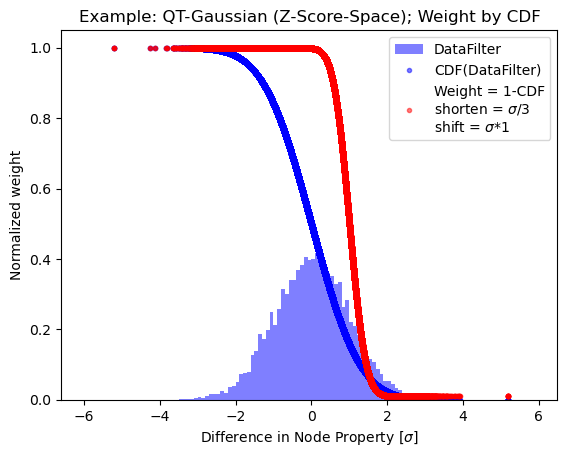

In [3]:
###################################
############# Imports #############
###################################
from scipy.stats import norm
from sklearn.preprocessing import QuantileTransformer


#########################################
############# Define QT/CDF #############
#########################################
# Set data as IQRFiltered that is mirrored on the at dataEdgeDiffIQRFiltered=0
# (no difference in adjacent node values)
xValuesFiltered = np.append(basins.Fields['Field2']['dataEdgeDiffIQRFiltered'],
                            -basins.Fields['Field2']['dataEdgeDiffIQRFiltered'])

# Create QT object and fit
qt = QuantileTransformer(n_quantiles=1000, random_state=0,  output_distribution='normal')
x  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

# Use the QT to convert the xValuesFiltered difference data into z-score space. 
xFiltered  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

# Define the cumulative density function in the z-score space. 
shortenFactor = 3;
shiftFactor = 1

qtDissSTD = 1
cdfCenter  = qtDissSTD*shiftFactor
cdfStretch = qtDissSTD/shortenFactor
normCDF = 1-1*norm.cdf(xFiltered, loc=cdfCenter, scale=cdfStretch)
normCDF2 = 1-1*norm.cdf(xFiltered, loc=0, scale=1)


################################
############# Plot #############
################################
# Plot subplot
fig, axes = plt.subplots(nrows=1, ncols=1);
# QT distribution
plt.sca(axes)

hist = plt.hist(xFiltered, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DataFilter', density=True);
plt.plot(xFiltered, normCDF2.T[0], 'b.',  alpha=.5, label='CDF(DataFilter)');

minWeight = 0.01;
#plt.hist(distribution2, alpha=.5, color='r', bins=np.arange(-6, 6, .1), label='Weighted location', density=True);
CDF_SS = (normCDF.T[0]+minWeight)/(1+minWeight);
plt.plot(xFiltered, CDF_SS, 'r.',  alpha=.5,
         label='Weight = 1-CDF\nshorten = $\sigma/{}$\nshift = $\sigma$*{}'.format(shortenFactor,shiftFactor));


plt.legend();
plt.xlabel(r"Difference in Node Property $[\sigma]$");
plt.ylabel("Normalized weight")
plt.title(r"Example: QT-Gaussian (Z-Score-Space); Weight by CDF");


# Identify what percentiles of of DataFilter are being captured with the shorten and shifted distribution
logical1 = (CDF_SS>minWeight) & (xFiltered.T[0]>=0)
logical2 = (CDF_SS>minWeight) & (CDF_SS<(1-minWeight)) & (xFiltered.T[0]>=0)
minmax_Xvalue1 = [np.min(xFiltered[logical1]), np.max(xFiltered[logical1])]
minmax_Xvalue2 = [np.min(xFiltered[logical2]), np.max(xFiltered[logical2])]

# The total percentage of data used to determine edge weights
# Multiple by 2 since the negative values are just a mirror of positive values.
percentData1 = 100*np.sum( hist[0][(hist[1][1:]>=minmax_Xvalue1[0]) & (hist[1][1:]<=minmax_Xvalue1[1])] )/np.sum(hist[0][(hist[1][1:]>=minmax_Xvalue1[0])])
percentData2 = 100*np.sum( hist[0][(hist[1][1:]>=minmax_Xvalue2[0]) & (hist[1][1:]<=minmax_Xvalue2[1])] )/np.sum(hist[0][(hist[1][1:]>=minmax_Xvalue1[0])])

print("About {:.2f} % of data is being weighted with non-min values".format(percentData1))
print("About {:.2f} % of data is being weighted with non-min/max values".format(percentData2))



# Figure 5: (Bathymetry Basin Detection 0 and 60 Myr)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
from xml.etree import ElementTree as ET

def plotGlobal_raster_layers(lat, lon, values,
               outputDir=os.getcwd(),
               fidName="plotGlobal.svg",
               cmapOpts={"cmap": "tab10", "cbar-title": "cbar-title"},
               pltOpts={"valueType": "Class",
                        "valueUnits": "",
                        "plotTitle": "",
                        "plotZeroContour": False,
                        "plotIntegerContours": False,
                        "transparent": True},
               savePNG=False,
               saveSVG=True,
               mergeSVG=True,
               deleteLayers=True,
               showColorbar=True):
    """
    Rasterized class-layer plotting with overlaid SVG layers and colorbar placed below the map.
    """
    os.makedirs(outputDir, exist_ok=True)

    # Class info
    unique_vals = np.unique(values[~np.isnan(values)])
    num_classes = len(unique_vals)
    base_cmap = plt.get_cmap(cmapOpts.get("cmap", "tab20"), num_classes)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    layer_paths = []

    # Setup colorbar elements for merging
    cmap = ListedColormap([base_cmap(i / (num_classes - 1)) for i in range(num_classes)])
    norm = BoundaryNorm(boundaries=np.append(unique_vals, unique_vals[-1] + 1), ncolors=num_classes)

    # Final composite figure (map + colorbar)
    fig = plt.figure(figsize=(10, 5.5))
    gs = GridSpec(10, 1, figure=fig)
    ax_map = fig.add_subplot(gs[0:9, 0], projection=ccrs.Mollweide())
    ax_map.set_global()
    ax_map.axis("off")

    # Plot each class as rasterized imshow
    for i, val in enumerate(unique_vals):
        mask = np.where(values == val, val, np.nan)
        color = base_cmap(i / (num_classes - 1)) if num_classes > 1 else base_cmap(0)
        single_cmap = ListedColormap([color])

        ax_map.imshow(mask, origin="upper", extent=extent,
                      transform=ccrs.PlateCarree(),
                      cmap=single_cmap, vmin=val, vmax=val + 1,
                      interpolation="none", rasterized=True)

    if pltOpts.get("plotIntegerContours", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            levels = np.arange(len(unique_vals)) + 0.5
            ax_map.contour(lon, lat, values_cp, levels=levels, colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    if pltOpts.get("plotZeroContour", False):
        try:
            values_cp = np.copy(values)
            values_cp[np.isnan(values_cp)] = 0
            ax_map.contour(lon, lat, values_cp, levels=[0], colors='black',
                           linewidths=0.5, transform=ccrs.PlateCarree())
        except:
            pass

    # Title
    ax_map.set_title(pltOpts.get("plotTitle", ""))
    ax_map.gridlines(draw_labels=False)

    # Horizontal colorbar below map
    if showColorbar:
        ax_cb = fig.add_subplot(gs[9, 0])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = plt.colorbar(sm, cax=ax_cb, orientation='horizontal',
                          ticks=unique_vals + 0.5)
        cb.ax.set_xticklabels( unique_vals.astype(int) )
        cb.set_label(label="{} [{}]".format(pltOpts['valueType'], pltOpts['valueUnits']), size=10)
        cb.ax.tick_params(labelsize=8)

    # Save final composite
    out_svg = os.path.join(outputDir, fidName)
    out_png = out_svg.replace(".svg", ".png")

    if saveSVG:
        plt.savefig(out_svg, format="svg", dpi=600, transparent=pltOpts.get("transparent", False))
    if savePNG:
        plt.savefig(out_png, format="png", dpi=600, transparent=pltOpts.get("transparent", False))

    plt.close()


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resolution: 0.01, ensembleSize: 50, minBasinCnt: 12
Storing images in figures/CommunityDetectionMethodsPaper/CompositeMethod_ReconBathy_4
agei 0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry

Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_0Ma.nc
	parameter: z
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field2
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_0Ma.nc
	parameter: z
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9138: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


sh: 1: temp.txt: not found
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
100%|█████████████████████████████████| 24534/24534 [00:05<00:00, 4310.03it/s]


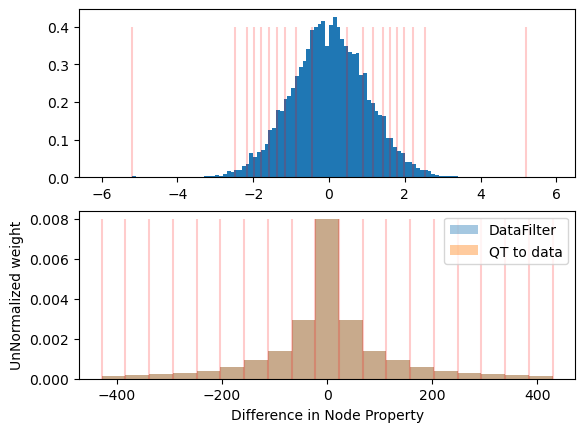

  9%|███▏                               | 2200/24534 [00:02<00:30, 731.14it/s]

In [ ]:
#################################################
#################### Imports ####################
#################################################
from netCDF4 import Dataset
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import copy as cp


###################################
## Define Functions for Figure 5 ##
###################################
def load_netcdf_data(age):
    # Read bathymetry file.
    ds = Dataset(os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age))

    # Assign data to variables
    lon, lat = np.meshgrid(ds['lon'][:], ds['lat'][:]);
    z = ds['z'][:].data;
    continents = ds['z'][:].mask;
    continentsnew = cp.deepcopy(continents).astype(float)
    continentsnew[continentsnew==0] = np.nan

    
    # Close dataset
    ds.close();
    
    # Return variables
    return lon, lat, z, continentsnew


#########################################
### Define Community Detection Inputs ###
#########################################
# plot Options
saveSVG = False;

# Reconstruction periods
#ages = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80];
#ages = [0, 60]


#########################################
### Define Community Detection Inputs ###
#########################################
# Simple test
#communityDetectionMethod = "Louvain"
#communityDetectionMethod = "Louvain-Girvan-Newman"
communityDetectionMethod = "Leiden"
communityDetectionMethod = "Leiden-Girvan-Newman"


# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
#mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
#resolutions = [0.01, 0.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
#minBasinCnts = [10, 10];
#minBasinCnts = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
#ensembleSizes = [50, 50];


# For periods
reconPeriod = {"0Ma":True, "60Ma":False}

## 0 Ma
if reconPeriod["0Ma"]:
    ages = [0]
    minBasinCnts = [12];
    resolutions = [0.01];
    ensembleSizes = [50];

## 60 Ma
if reconPeriod["60Ma"]:
    ages = [60]
    minBasinCnts = [120];
    minBasinCnts = [25];
    resolutions = [0.01];
    ensembleSizes = [50];

# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]
#mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;


# Define strings for ages and minimum basin count
agestr = [ str(age) for age in ages ];
minBasinCntVstr = [ str(cnt) for cnt in minBasinCnts ];


# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print("resolution: {}, ensembleSize: {}, minBasinCnt: {}".format(resolution, ensembleSize, minBasinCnt))
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}
    # edgeWeightMethod = {"method":"useLogistic"}


    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/CompositeMethod_ReconBathy')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values ({0} Ma) are shown with a colorbar that represents 1 std that are area weighted.".format(", ".join(agestr));
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: [{}]".format(", ".join(minBasinCntVstr));
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################
    for i in range(len(ages)):
        # Set reconstruction parameters
        agei = ages[i]

        print("agei",agei)



        # Create basin object
        body = ["Earth", "Mars", "Venus", "Moon"]
        body = body[0]
        basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                                 filename="{}_resampled_1deg.nc".format(body),
                                 body=body);

        # Add bathymetry field
        basins.addField(resolution = basins.Fields["Field1"]["resolution"],
                        dataGrid =  os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(agei),
                        parameter = "z",
                        parameterUnit = basins.Fields["Field1"]["parameterUnit"],
                        parameterName = basins.Fields["Field1"]["parameterName"])
        
        # Assign fields to use in community detection (reconstructed field)
        basins.useFields(fieldList=np.array(["Field2"]))

        # Show all fields stored in basins object
        basins.getFields(usedFields = False)

        # Show all fields stored in basins object that will be used
        # for community detection.
        basins.getFields(usedFields = True)

        # Set field mask parameters
        fieldMaskParameter = {"usedField":0, "fliprl":False, "flipud":True}
        #basins.setFieldMask(usedField = 0, fliprl=False, flipud=True)

        #########################################
        ### Run Community Detection Algorithm ###
        #########################################

        # Define basins based on user input boundaries.
        # For the Louvain-Girvan-Newman composite algorithm the variable
        # minBasinCnt refers to the number of basins to maintain that are
        # not completely isolated after running the louvain algorithm.
        basins.defineBasins(detectionMethod = detectionMethod,
                            edgeWeightMethod = edgeWeightMethod,
                            fieldMaskParameter = fieldMaskParameter,
                            reducedRes={"on":True,"factor":1},
                            read=False,
                            write=True,
                            verbose=False)


        # Merge communities based off criteria 
        basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

        # Convert basinID equal area grid to regular grid
        basins.interp2regularGrid(mask=True)

        #####################################
        ### Plot results of community IDs ###
        #####################################
        EC.utils.plotGlobal(basins.lat, basins.lon, cp.deepcopy(basins.BasinIDA),
                            outputDir = os.getcwd()+"/"+fldName,
                            fidName = "plotGlobal_{0}.png".format(agei),
                            cmapOpts={"cmap":"jet",
                                      "cbar-title":"cbar-title",
                                      "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                            pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                     "valueUnits": "-",
                                     "plotTitle":"",
                                     "plotZeroContour":False,
                                     "plotIntegerContours":True,
                                     "transparent":True},
                            savePNG=True,
                            saveSVG=saveSVG)


        plotGlobal_raster_layers(
            lat=basins.lat,
            lon=basins.lon,
            values=cp.deepcopy(basins.BasinIDA),
            outputDir=os.path.join(os.getcwd(), fldName),
            fidName="plotGlobal_{0}_layered.svg".format(agei),
            cmapOpts={
                "cmap": "jet",
                "cbar-title": "Basin ID"
            },
            pltOpts={
                "valueType": "BasinID / {}".format(basins.Fields["Field1"]["parameterName"]),
                "valueUnits": "-",
                "plotTitle": "Basin Classification at {} Ma".format(agei),
                "plotZeroContour": False,
                "plotIntegerContours": True,
                "transparent": True
            },
            savePNG=False,
            saveSVG=True,
            mergeSVG=False,  # no merging needed since everything is now in one figure
            deleteLayers=True,
            showColorbar=True
        )


        # Calculate area weighted average and standard deviation (for plotting)
        areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                                  LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                                  LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
        ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

        #########################
        ### Plot input fields ###
        #########################
        EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                            outputDir = os.getcwd()+"/"+fldName,
                            fidName = "plotGlobal_{0}_{1}.png".format(basins.Fields["Field1"]['parameterName'], agei),
                            cmapOpts={"cmap":"jet",
                                      "cbar-title":"cbar-title",
                                      "cbar-range":[ave-1*std,
                                                    ave+1*std]},
                            pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                     "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                     "plotTitle":"",
                                     "plotZeroContour":False,
                                     "transparent":True},
                            savePNG=True,
                            saveSVG=saveSVG)


# Testing and development (delete)

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 10
Storing images in figures/CommunityDetectionMethodsPaper/TestingAndDevelopment-delete_8

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9199: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4372.72it/s]


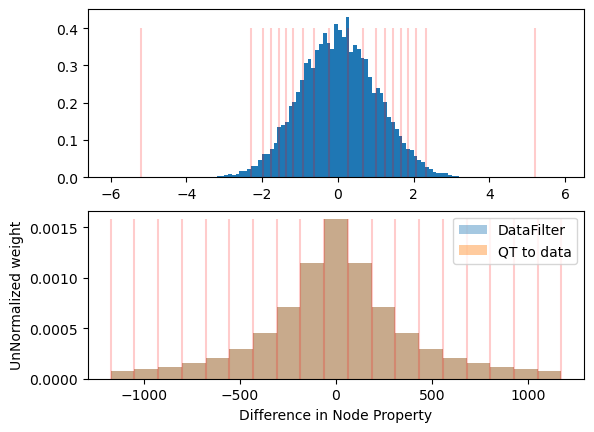

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:29<00:00, 818.49it/s]


Network has been overwritten.
Network has been overwritten.


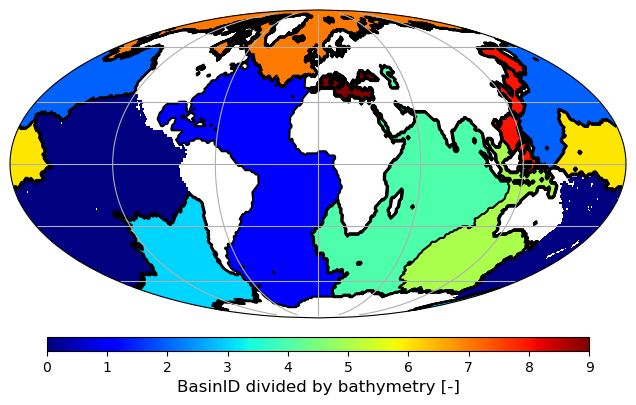

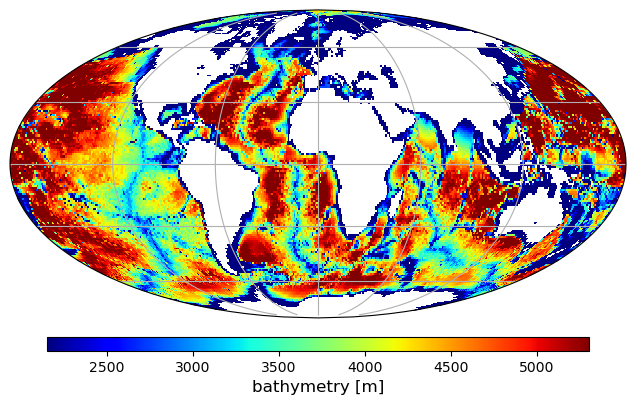

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
# Options:
#     "Louvain", "Louvain-Girvan-Newman",
#     "Leiden", "Leiden-Girvan-Newman"
communityDetectionMethod = "Leiden-Girvan-Newman"


# Define basin merging criteria
mergerPackageName = 'Lite'; # ['threshold'] = [0.1, 0.5]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [10]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}


    # Make folder to hold figure results
    !mkdir -p figures/CommunityDetectionMethodsPaper/
    fldName = EC.utils.makeFolderSeries(fldBase='figures/CommunityDetectionMethodsPaper/TestingAndDevelopment-delete')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    if edgeWeightMethod['method'] == "useQTGaussianShiftedGaussianWeightDistribution":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nUsing S/distanceV edge weight";
        readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
        readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
        readmetxt += "\nThe CDF used for S is calculated as follows:";
        readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
        readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
        readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
        readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
        readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
        readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
        readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLeiden resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nLeiden ensemble size: {}".format(detectionMethod["ensembleSize"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";
    elif edgeWeightMethod['method'] == "useLogistic":
        readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
        readmetxt = "\nUsing model S <- useLogistic with standard parameters.";
        readmetxt = "\nUsing S/distanceV edge weight";
        readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
        readmetxt += "\nLouvain resolution: {}".format(detectionMethod["resolution"]);
        readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
        readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

        readmetxt += "\n";
        readmetxt += "\nTesting: Results should not be used for publication";


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)
    


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)
